# Milestone P3

# Milestone Objectives

- Execute the project: single final notebook (main logic), helpers python file (implementations functions).

- Write a data story

- Update README: details the contributions of all group members.

[Milestone P3 briefing](https://epfl-ada.github.io/teaching/fall2023/cs401/projects/#p3-final-project-and-the-datastory)

In [3]:
import os

from helpers import *
# from implementations import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import nltk
nltk.download('punkt')
import re
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\paulr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Data Path
DATA_PATH = '../data/'
MOVIES_FOLDER = DATA_PATH+'MovieSummaries/'
MOVIES_DATASET = MOVIES_FOLDER+"movie.metadata.tsv"

# Load Data
df = pd.read_csv(MOVIES_DATASET, sep='\t', names=['id_wiki','id_freebase','name','date',
                                                  'box_office','runtime','lang','countries','genres'])

# Structure

# 0) Overview of the data used (Milestone P2)

## 0-a) Overall overview of the dataset

First, let's take a global view of what we have in the CMU movie dataset. We'll explore the dataset's overall structure, key variables, and initial characteristics to better understand the scope and content of the data before delving into specific analyses and preprocessing steps.

In [5]:
print("We have a total number of {} movies in the dataset ".format(len(df)))


We have a total number of 81741 movies in the dataset 


In [6]:
print('Features of the dataset:')
print(df.columns.values)

Features of the dataset:
['id_wiki' 'id_freebase' 'name' 'date' 'box_office' 'runtime' 'lang'
 'countries' 'genres']


- **id_wiki:** This is a unique identifier associated with each movie on Wikipedia.

- **id_freebase:** This is a unique identifier associated with each movie on Freebase. This feature provides no useful information, as databases from Freebase were merged with Wikipedia in 2014.

- **name:** Title of the movie.

- **date:** Date of release of the movie.

- **box_office:** Contains the box office revenue in dollars.

- **runtime:** Duration of the film in minutes.

- **lang:** This column indicates the languages used in the original (VO) movie.

- **countries:** This column is associated with the country of production of the movie.

- **genres:** Genres associated with the film.


Let's see an example with our favorite movie saga: *Twilight*.

But where are our precious movies? As the dataframe contains 80,000 movies, we need to find which ones contain the word "Twilight" in the title name.


In [7]:

result = df[df['name'].str.contains('twilight', case=False, na=False)]
display(' Movie title that contains Twilight \n', result['name'] )

' Movie title that contains Twilight \n'

2673                                     Women of Twilight
3241                              Twilight's Last Gleaming
7447                           Twilight of the Dark Master
9863                                      Twilight Dancers
9912             The Twilight Saga: Breaking Dawn - Part 1
13863    Memories of Berlin: The Twilight of Weimar Cul...
14223                                             Twilight
18376                                       Tokyo Twilight
19856                             Twilight Zone: The Movie
27507                              The Kingdom of Twilight
33617                          Twilight of the Cockroaches
33659                                             Twilight
35389                                     Twilight Theater
41159                                    Twilight of Honor
41604                                 The Twilight Samurai
42224                              Sir Galahad of Twilight
42881                                 Twilight of the Go

In [8]:
print( 'We have a total of {} movie that contain Twilight in their title'.format(len(result)))

We have a total of 29 movie that contain Twilight in their title


That's more than we expected! Anyway, I see my favorite one: *The Twilight Saga: Breaking Dawn - Part 1*. Let's analyze the features of this movie.


In [9]:
FILM_NAME='The Twilight Saga: Breaking Dawn - Part 1'

print('Released date: {} \n' .format(df[
    df['name']==FILM_NAME]['date'].values[0]))

print('Genres: {} \n'.format(df[
    df['name']==FILM_NAME]['genres'].values[0]))

print('Countries of production: {} \n'.format(df[
    df['name']==FILM_NAME]['countries'].values[0]))


print('Box office revenues : {:,.0f}$ \n'.format(df[
    df['name']==FILM_NAME]['box_office'].values[0]))

print('Duration : {:.0f} minutes \n'.format(df[
    df['name']==FILM_NAME]['runtime'].values[0]))

print('Language adaptation :{}' .format(df[
    df['name']==FILM_NAME]['lang'].values[0]))

Released date: 2011-11-16 

Genres: {"/m/07s9rl0": "Drama", "/m/01hmnh": "Fantasy", "/m/03k9fj": "Adventure", "/m/02b5_l": "Teen", "/m/03rzvv": "Romantic fantasy"} 

Countries of production: {"/m/09c7w0": "United States of America"} 

Box office revenues : 705,058,657$ 

Duration : 117 minutes 

Language adaptation :{"/m/02h40lc": "English Language"}


As we can see, some features are not that clean, like **genre, countries, and language adaptation**. These features will need to be treated in the second part.


After examining the features for the film *The Twilight Saga: Breaking Dawn - Part 1*, let's delve into a broader understanding of the dataset. Now, shifting our focus to the entire dataset, we aim to provide a comprehensive overview.


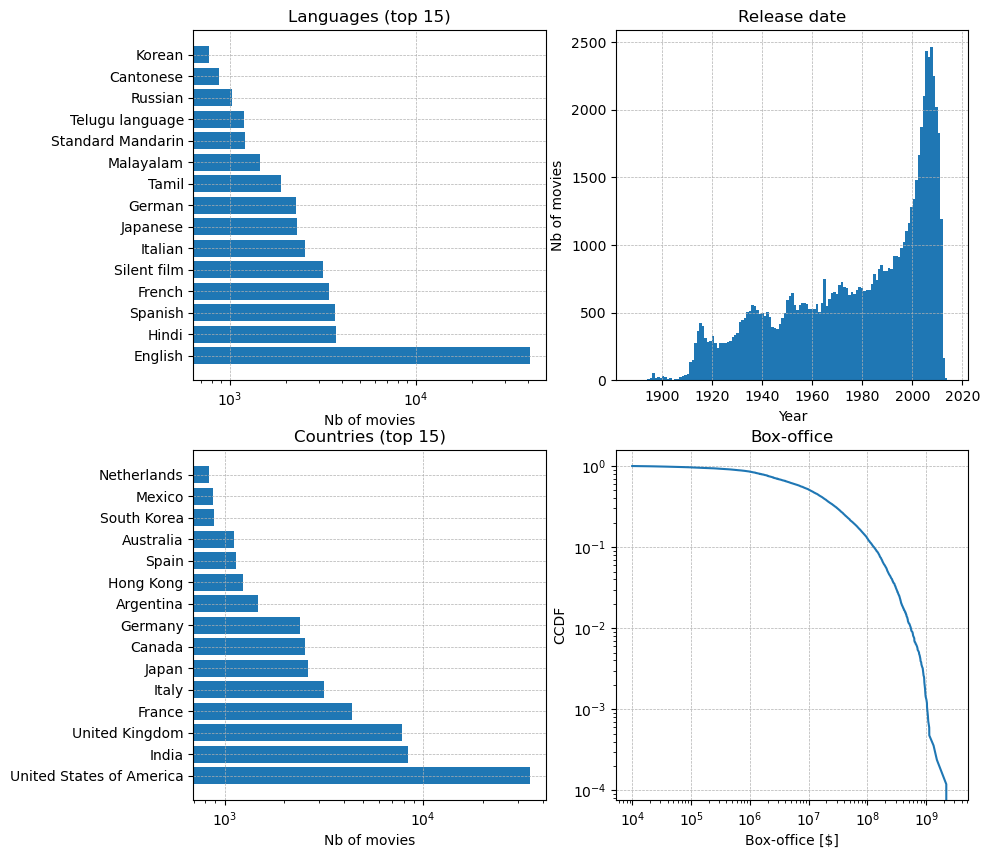

In [10]:
data_viz(df, israw=True)

## 0-b) Cleaning the data

This part focuses on cleaning the data. Indeed, cleaning data is an important step for accurate data analysis. It ensures the integrity of results, reduces the risk of errors, and promotes consistency in reporting. Clean data enhances data understanding, uncovering valuable insights and patterns. Moreover, it facilitates compatibility with other datasets, mitigates bias, and ensures compliance with industry regulations. In essence, data cleaning is an essential step that contributes to the overall quality and effectiveness of data-driven processes. But first things first, let's make a deep copy of the dataset before filtering.


In [11]:
movies = df.copy()

### i) Removing missing data :

First let's have a look at what is missing in the original dataframe *'df'*

In [12]:
generate_missing_info(df)

,Missing Data (%)
Column,
id_wiki,0.00
id_freebase,0.00
name,0.00
date,8.44
box_office,89.72
runtime,25.02
lang,0.00
countries,0.00
genres,0.00


In order to identify pivotal movies, some features of data are crucial. First is data linked to trend identification. To identify trends for movies, we need two features: the **date of release** and the **genres** of the movie. Then, we remove all movies that have either a missing date feature or a missing genres feature.


In [13]:
# Handle missing values
movies = data_missing(movies)

Now let's check if there are any duplicates. We define a duplicate pair as movies with the same name, release year, and runtime.


In [14]:
check_doublons(movies,['name'],'date','runtime')

Rows with real duplicates: 
                                     name        date  runtime
1412                       Landspeed: CKY        1999      NaN
4856   Indiana Jones and the Last Crusade  1989-05-24    127.0
5356                       Landspeed: CKY        1999      NaN
5872                    Secrets of Nature        1950      NaN
9965                      Little Big Horn  1951-06-15     86.0
13458                    Jeepers Creepers        1939      NaN
16448                 Moscow Strikes Back  1942-02-23     55.0
24940                   Secrets of Nature        1950      NaN
31701                    Facing the Music  1941-10-18     79.0
45846                 Moscow Strikes Back  1942-02-23     55.0
46001                    Jeepers Creepers        1939      NaN
49203  Indiana Jones and the Last Crusade  1989-05-24    127.0
51505                Yours, Mine and Ours  2005-11-23     88.0
61322                     Little Big Horn  1951-06-15     86.0
62250                      

'--------------------------------------------------------------------------------'

Interesting! Looks like we have some duplicates. We'll merge them so that we keep all the relevant information. For example, let's look at the Indiana Jones movie.


In [15]:
display(movies[movies['name'] == 'Indiana Jones and the Last Crusade'])

,id_wiki,id_freebase,name,date,box_office,runtime,lang,countries,genres
4856,3184269,/m/0dnqr,Indiana Jones and the Last Crusade,1989-05-24,NaN,127.0,"{""/m/0349s"": ""Greek Language"", ""/m/04306rv"": ""...","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3m_6"": ""Costume Adventure"", ""/m/02kdv5..."
49203,51888,/m/0h_b6x1,Indiana Jones and the Last Crusade,1989-05-24,474171806.0,127.0,{},{},"{""/m/03k9fj"": ""Adventure""}"


After merging :

In [16]:
movies = fuse_duplicates(movies, col_check=['name'], year='date', runtime='runtime',
                         col_len=['lang', 'countries', 'genres'], col_null=['box_office', 'runtime'])
display(movies[movies['name']=='Indiana Jones and the Last Crusade'])


Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------


,id_wiki,id_freebase,name,date,box_office,runtime,lang,countries,genres
4452,3184269,/m/0dnqr,Indiana Jones and the Last Crusade,1989-05-24,474171806.0,127.0,"{""/m/0349s"": ""Greek Language"", ""/m/04306rv"": ""...","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3m_6"": ""Costume Adventure"", ""/m/02kdv5..."


In [17]:
print('The remaining values of movies after this step is {}'.format(len(movies)))


The remaining values of movies after this step is 74830


### ii) Changing the features format

Now that the missing data has been dropped, we will address unclear features in the dataset. Building on the example of 'Twilight' from part 1, we observed that the presentation of languages, countries, and genres needed improvement. Let's reorganize and standardize these features for better clarity. Additionally, we'll modify the date format to establish a consistent basis for every film in the dataset.


In [18]:
# Format data types
movies = data_format(movies)

Let's take a look to the refresh features

In [19]:
print('Released date: {} \n' .format( movies[
    movies['name']==FILM_NAME]['date'].values[0]))

print('Genres: {} \n'.format( movies[
    movies['name']==FILM_NAME]['genres'].values[0]))

print('Countries of production: {} \n'.format(    movies[
       movies['name']==FILM_NAME]['countries'].values[0]))
  

print('Language adaptation :{}' .format(movies[
        movies['name']==FILM_NAME]['lang'].values[0]))

Released date: 2011 

Genres: ['Drama', 'Fantasy', 'Adventure', 'Teen', 'Romantic fantasy'] 

Countries of production: ['USA'] 

Language adaptation :['English Language']


Nice! Now we see clearly the genre, countries of production, and language adaptation. Furthermore, we only keep the year the film has been released for our further analysis.

For the sake of simplicity, we rename the column 'date' to 'year' and the column 'box_office' to 'revenue'.


In [20]:
movies.rename(columns={'box_office': 'revenue'}, inplace=True)
movies.rename(columns={'date': 'year'}, inplace=True)


### iii) Boundary definition

To ensure the accuracy of our data for analysis, it is crucial to define boundaries within the 'date' feature. Occasionally, incorrect data may be present, leading to inconsistencies. Let's identify and rectify such errors to maintain data integrity and ensure meaningful analysis.


In [21]:
display(movies[movies['year']<1800][['name','year']])

,name,year
57565,Hunting Season,1010


Turns out the Middle Ages had more drama than we thought, the first medieval blockbusters are here! But all jokes aside, let's clean it.


In [22]:
# Clean data, outliers and features
movies = data_clean(movies)


### iv) Filtering data

The last step is to filter our data. Indeed, we want to focus our analysis only on movies produced in the USA and in the English language.


In [23]:
movies_all= movies.copy()
# Filter data
movies = data_filter(movies)

Let's look at what is remaining and what distributions look likes

In [24]:
generate_missing_info(movies)

,Missing Data (%)
Column,
id_wiki,0.00
id_freebase,0.00
name,0.00
year,0.00
revenue,77.56
runtime,10.79
lang,0.00
countries,0.00
genres,0.00


In [25]:
display(movies.info())

<class 'pandas.core.frame.DataFrame'>
Index: 28821 entries, 0 to 74827
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  object 
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(6)
memory usage: 2.1+ MB


None

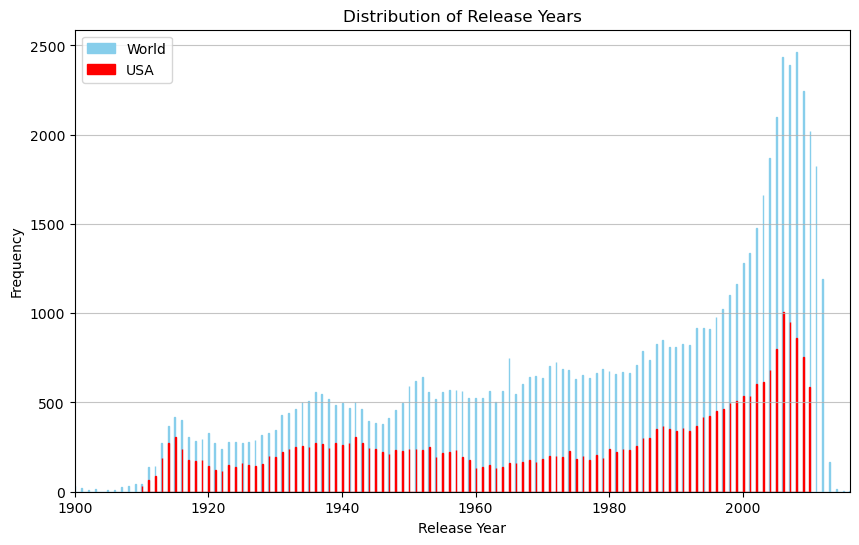

In [26]:
# Looking at distribution of release years

plt.figure(figsize=(10, 6))
plt.hist(movies_all['year'], bins=1000, color='skyblue', edgecolor='skyblue', label='World')
plt.hist(movies['year'], bins=1000, color='red', edgecolor='red', label='USA')
plt.xlabel("Release Year")
plt.xlim(1900, 2016)
plt.ylabel("Frequency")
plt.title("Distribution of Release Years")
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()


It seems that a lot of revenue data is missing. Let's examine the distribution along the years.



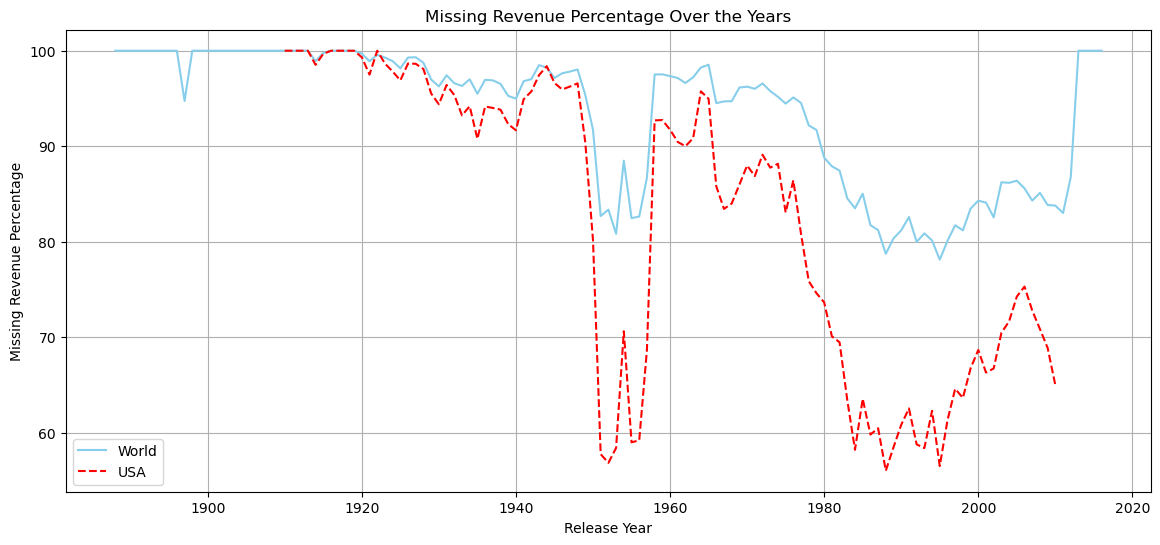

In [27]:
# Let's compare missing revenue data for some countries

missing_revenue_all = calculate_missing_percentage(movies_all, 'year', 'revenue')
missing_revenue_USA = calculate_missing_percentage(movies, 'year', 'revenue')


plt.figure(figsize=(14, 6))

plt.plot(missing_revenue_all.index, missing_revenue_all["revenue"], linestyle='-', color='skyblue', label='World')
plt.plot(missing_revenue_USA.index, missing_revenue_USA["revenue"], linestyle='--', color='r', label='USA')

plt.xlabel("Release Year")
plt.ylabel("Missing Revenue Percentage")
plt.title("Missing Revenue Percentage Over the Years")
plt.grid()
plt.legend()
plt.show()


As seen in the graph above, the missing value percentage for revenue is relatively high across all years (although the USA-only data is cleaner). We will try to address this using additional datasets (cf README).


## 0-c) Enrich the data

As seen in the previous part a lot data is missing for the revenue column. Furthermore, for future analysis of pivotal movies (cf README), we would like to have a review feature. This feature will take value from 0 to 10 and will be linked to another feature : number of reviews available.

In [28]:
MOVIE_STATS = DATA_PATH + 'movie-stats/movies_stats.csv'
MOVIE_LENS = DATA_PATH +'movie_lens/movies_lens.csv'


### i) Loading and cleaning movie-stats

In [29]:
# Loading MovieStats movies df

movies_stats_vanilla = pd.read_csv(MOVIE_STATS)
movies_stats_vanilla.drop(columns=
                          ['genre', 'released', 'director', 'writer',
                           'star', 'company', 'rating', 'budget'], 
                          inplace=True)
movies_stats_vanilla = movies_stats_vanilla.rename(columns={
                                                   'gross': 'revenue',
                                                   'country': 'countries',
                                                   'score': 'review',
                                                   'votes': 'nbr_review'})
display(movies_stats_vanilla.sample(5))
display(movies_stats_vanilla.shape)
display(movies_stats_vanilla.info())
generate_missing_info(movies_stats_vanilla)


,name,year,review,nbr_review,countries,revenue,runtime
1884,The Commitments,1991,7.6,34000.0,Ireland,14919570.0,118.0
45,Cheech and Chong's Next Movie,1980,6.1,12000.0,United States,41675194.0,99.0
6253,The Hobbit: The Desolation of Smaug,2013,7.8,615000.0,New Zealand,959007513.0,161.0
4142,Eye See You,2002,5.3,25000.0,Germany,6632383.0,96.0
5275,The Happening,2008,5.0,199000.0,United States,163403799.0,91.0


(7668, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        7668 non-null   object 
 1   year        7668 non-null   int64  
 2   review      7665 non-null   float64
 3   nbr_review  7665 non-null   float64
 4   countries   7665 non-null   object 
 5   revenue     7479 non-null   float64
 6   runtime     7664 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 419.5+ KB


None

,Missing Data (%)
Column,
name,0.00
year,0.00
review,0.04
nbr_review,0.04
countries,0.04
revenue,2.46
runtime,0.05


- Checking release year distribution and country representation

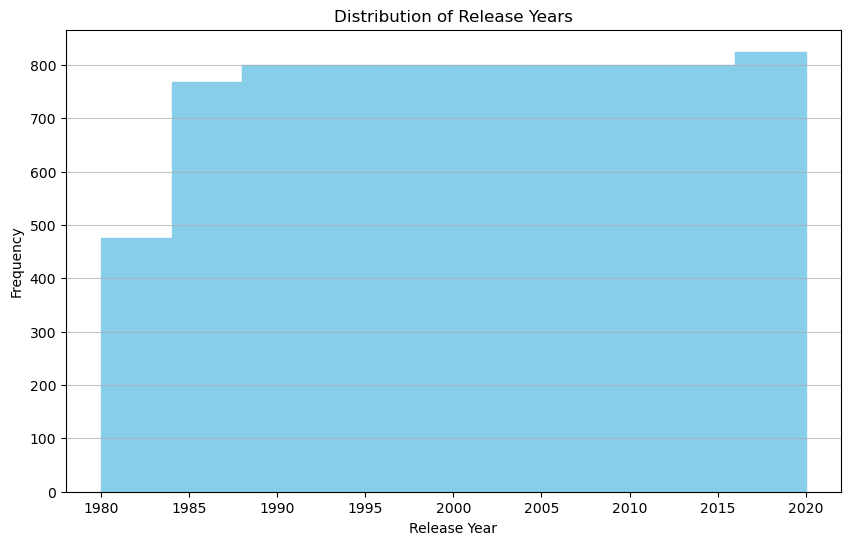

countries
United States     5475
United Kingdom     816
France             279
Canada             190
Germany            117
Australia           92
Japan               81
India               62
Italy               61
Spain               47
Name: count, dtype: int64

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(movies_stats_vanilla['year'], color='skyblue', edgecolor='skyblue')
plt.xlabel("Release Year")
plt.ylabel("Frequency")
plt.title("Distribution of Release Years")
plt.grid(axis='y', alpha=0.75)
plt.show()

display(movies_stats_vanilla['countries'].value_counts().head(10))



- Keep only relevant rows: positive box office and USA only, checking date and runtime.


In [31]:


movies_stats = movies_stats_vanilla.copy(deep=True)

movies_stats = movies_stats.drop(movies_stats.index[movies_stats['year']<1800])
movies_stats.loc[movies_stats['runtime'] < 0, 'runtime'] = 0
movies_stats['runtime'] = movies_stats['runtime'].replace(0, pd.NA)

zero_data = movies_stats[(movies_stats.revenue <= 0)|(movies_stats.revenue.isna())|(movies_stats['countries']!='United States')]
movies_stats.drop(zero_data.index,inplace=True)
display(movies_stats.sample(5))
display(movies_stats.shape)
display(movies_stats.info())
generate_missing_info(movies_stats)


,name,year,review,nbr_review,countries,revenue,runtime
1014,Jake Speed,1986,5.2,879.0,United States,1943751.0,105.0
4952,Open Season,2006,6.1,89000.0,United States,200811689.0,86.0
1073,Overboard,1987,6.9,55000.0,United States,26713187.0,112.0
2057,Sister Act,1992,6.4,91000.0,United States,231605150.0,100.0
2742,Grumpier Old Men,1995,6.7,25000.0,United States,71518503.0,101.0


(5377, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 5377 entries, 1 to 7659
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        5377 non-null   object 
 1   year        5377 non-null   int64  
 2   review      5377 non-null   float64
 3   nbr_review  5377 non-null   float64
 4   countries   5377 non-null   object 
 5   revenue     5377 non-null   float64
 6   runtime     5376 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 336.1+ KB


None

,Missing Data (%)
Column,
name,0.00
year,0.00
review,0.00
nbr_review,0.00
countries,0.00
revenue,0.00
runtime,0.02


- Check if there are any duplicates

In [32]:
display(check_doublons(movies_stats, ['name'], 'year', 'runtime'))


No duplicates


'--------------------------------------------------------------------------------'

Perfect now the first additional dataset is clean(er) !

### ii) Loading and cleaning movie lens dataset

- Loading Lens movies df

In [33]:
movies_lens_vanilla = pd.read_csv(MOVIE_LENS, usecols=['title', 'release_date', 'production_countries', 'revenue', 'runtime',
                                                      'vote_average', 'vote_count'])
movies_lens_vanilla = movies_lens_vanilla.rename(columns={'production_countries': 'countries',                                                     
                                                         'title': 'name',
                                                         'vote_average': 'review',
                                                         'vote_count': 'nbr_review'})
display(movies_lens_vanilla.sample(5))
display(movies_lens_vanilla.shape)
display(movies_lens_vanilla.info())


,countries,release_date,revenue,runtime,name,review,nbr_review
3514,"[{'iso_3166_1': 'FR', 'name': 'France'}]",1998-05-15,0.0,122.0,Those Who Love Me Can Take the Train,4.5,3.0
44091,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2010-01-14,0.0,60.0,The Secret Life of Chaos,6.5,2.0
26204,"[{'iso_3166_1': 'US', 'name': 'United States o...",1957-06-28,0.0,94.0,The Seventh Sin,6.0,1.0
16272,"[{'iso_3166_1': 'US', 'name': 'United States o...",2008-11-07,0.0,72.0,Pray the Devil Back to Hell,7.0,3.0
23677,[],1980-08-15,0.0,115.0,Willie and Phil,0.0,0.0


(45466, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   countries     45463 non-null  object 
 1   release_date  45379 non-null  object 
 2   revenue       45460 non-null  float64
 3   runtime       45203 non-null  float64
 4   name          45460 non-null  object 
 5   review        45460 non-null  float64
 6   nbr_review    45460 non-null  float64
dtypes: float64(4), object(3)
memory usage: 2.4+ MB


None

- Keep only relevant columns, check budget and runtime

In [34]:
movies_lens = movies_lens_vanilla.copy(deep=True)
zero_data = movies_lens[(movies_lens.revenue <= 0)|(movies_lens.revenue.isna()|movies_lens.release_date.isna())]
movies_lens.drop(zero_data.index,inplace=True)
movies_lens.reset_index(drop=True, inplace=True)

movies_lens.loc[:, 'year'] = movies_lens['release_date'].str.split('-', expand=True)[0]
movies_lens.loc[:, 'year'] = movies_lens['year'].astype(int)
movies_lens = movies_lens.drop(columns='release_date')


movies_lens.loc[movies_lens['runtime'] < 0, 'runtime'] = 0
movies_lens['runtime'] = movies_lens['runtime'].replace(0, pd.NA)

movies_lens['year'] = movies_lens['year'].astype(int)
movies_lens['runtime'] = pd.to_numeric(movies_lens['runtime'], errors='coerce')



display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())



,countries,revenue,runtime,name,review,nbr_review,year
5075,"[{'iso_3166_1': 'US', 'name': 'United States o...",563749323.0,103.0,The Smurfs,5.5,1201.0,2011
3739,"[{'iso_3166_1': 'US', 'name': 'United States o...",326551094.0,109.0,The Devil Wears Prada,7.0,3198.0,2006
5299,"[{'iso_3166_1': 'US', 'name': 'United States o...",234989584.0,113.0,American Reunion,6.1,1641.0,2012
3519,"[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...",23727301.0,129.0,Russian Dolls,6.8,156.0,2005
550,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",50000000.0,183.0,The Deer Hunter,7.8,943.0,1978


(7407, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7407 entries, 0 to 7406
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   countries   7407 non-null   object 
 1   revenue     7407 non-null   float64
 2   runtime     7380 non-null   float64
 3   name        7407 non-null   object 
 4   review      7407 non-null   float64
 5   nbr_review  7407 non-null   float64
 6   year        7407 non-null   int32  
dtypes: float64(4), int32(1), object(2)
memory usage: 376.3+ KB


None

In [35]:
# Handling format
movies_lens['countries'] = movies_lens['countries'].apply(lambda x: [country['name'] for country in ast.literal_eval(x)] if pd.notna(x) else [])

# Handle multi-countries movies to keep only one country per movie (prioritize USA above others)
movies_lens = separate_values_biased(movies_lens, 'countries', 'United States of America')

display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())


,countries,revenue,runtime,name,review,nbr_review,year
5443,United States of America,30353232.0,101.0,Alex Cross,5.1,303.0,2012
3184,United States of America,10090429.0,98.0,Under the Cherry Moon,5.7,12.0,1986
3169,United States of America,171183863.0,101.0,AVP: Alien vs. Predator,5.6,1241.0,2004
709,NaN,10082.0,124.0,The Locusts,3.8,3.0,1997
3739,United States of America,326551094.0,109.0,The Devil Wears Prada,7.0,3198.0,2006


(7407, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7407 entries, 0 to 7406
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   countries   7255 non-null   object 
 1   revenue     7407 non-null   float64
 2   runtime     7380 non-null   float64
 3   name        7407 non-null   object 
 4   review      7407 non-null   float64
 5   nbr_review  7407 non-null   float64
 6   year        7407 non-null   int32  
dtypes: float64(4), int32(1), object(2)
memory usage: 376.3+ KB


None

- Keep only the USA

In [36]:
movies_lens = movies_lens[movies_lens['countries']=='United States of America'].drop(
columns='countries')

display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())



,revenue,runtime,name,review,nbr_review,year
1228,190458706.0,127.0,Superman II,6.5,642.0,1980
732,121214377.0,129.0,Starship Troopers,6.7,1584.0,1997
5190,177584879.0,146.0,War Horse,7.0,1016.0,2011
1639,354248063.0,82.0,Dinosaur,6.2,563.0,2000
3173,78000586.0,114.0,Exorcist: The Beginning,4.7,189.0,2004


(5623, 6)

<class 'pandas.core.frame.DataFrame'>
Index: 5623 entries, 0 to 7396
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   revenue     5623 non-null   float64
 1   runtime     5623 non-null   float64
 2   name        5623 non-null   object 
 3   review      5623 non-null   float64
 4   nbr_review  5623 non-null   float64
 5   year        5623 non-null   int32  
dtypes: float64(4), int32(1), object(1)
memory usage: 285.5+ KB


None

- Check if there are any duplicates

In [37]:
display(check_doublons(movies_lens, ['name'], 'year', 'runtime'))


Rows with real duplicates: 
                                             name  year  runtime
415                            A Farewell to Arms  1932     89.0
2301                                Clockstoppers  2002     94.0
2444  Pokémon 4Ever: Celebi - Voice of the Forest  2001     75.0
2548              Confessions of a Dangerous Mind  2002    113.0
4721                           A Farewell to Arms  1932     89.0
6692                                Clockstoppers  2002     94.0
6695              Confessions of a Dangerous Mind  2002    113.0
7381  Pokémon 4Ever: Celebi - Voice of the Forest  2001     75.0


'--------------------------------------------------------------------------------'

In [38]:
movies_lens = fuse_duplicates(movies_lens, col_check=['name'], year='year', runtime='runtime',
                         col_len=[], col_null=['revenue', 'review', 'nbr_review'])
check_doublons(movies_lens, ['name'], 'year', 'runtime')


Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
No duplicates


'--------------------------------------------------------------------------------'

- Check release year distribution

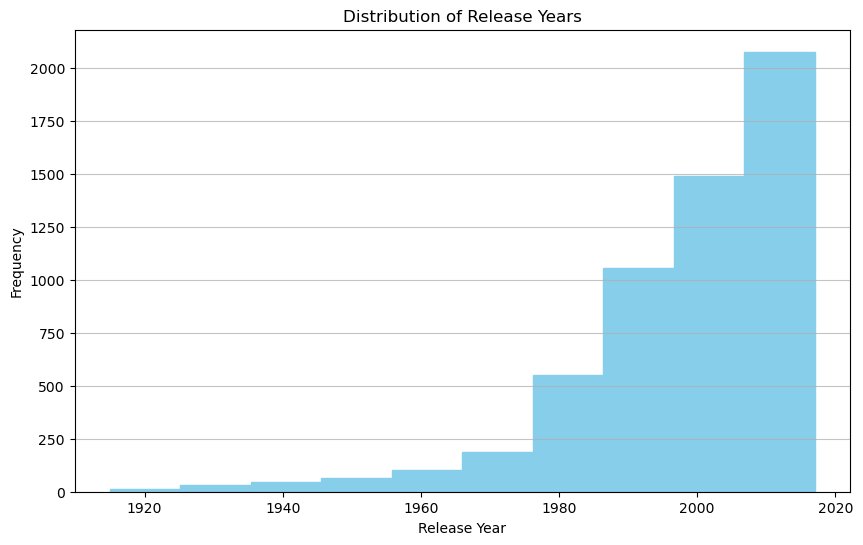

In [39]:
plt.figure(figsize=(10, 6))
plt.hist(movies_lens['year'], color='skyblue', edgecolor='skyblue')
plt.xlabel("Release Year")
plt.ylabel("Frequency")
plt.title("Distribution of Release Years")
plt.grid(axis='y', alpha=0.75)
plt.show()


### iii) Merging the two extra dataframes

Now that the two extra datasets are clean, let's merge them into the annex dataframe.

In [40]:
annex = pd.merge(movies_stats, movies_lens, how='outer', on=['name', 'year', 'runtime'])

display(annex.sample(5))
display(annex.shape)
display(annex.info())


,name,year,review_x,nbr_review_x,countries,revenue_x,runtime,revenue_y,review_y,nbr_review_y
1735,Money for Nothing,1993,5.7,3700.0,United States,1039824.0,100.0,1044824.0,5.1,21.0
8077,Bad Santa 2,2016,NaN,NaN,NaN,NaN,87.0,17782178.0,5.0,216.0
2549,Any Given Sunday,1999,6.9,114000.0,United States,100230832.0,162.0,NaN,NaN,NaN
6526,Mad Dog and Glory,1993,NaN,NaN,NaN,NaN,96.0,11081586.0,5.5,78.0
7768,Justin Bieber: Never Say Never,2011,NaN,NaN,NaN,NaN,105.0,98441954.0,4.8,156.0


(8136, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          8136 non-null   object 
 1   year          8136 non-null   int64  
 2   review_x      5377 non-null   float64
 3   nbr_review_x  5377 non-null   float64
 4   countries     5377 non-null   object 
 5   revenue_x     5377 non-null   float64
 6   runtime       8135 non-null   float64
 7   revenue_y     5619 non-null   float64
 8   review_y      5619 non-null   float64
 9   nbr_review_y  5619 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 635.8+ KB


None

- Let's merge the revenues columns

In [41]:
annex['revenue'] = annex.apply(lambda row: fuse_columns(row[f'revenue_x'], row[f'revenue_y'], 'revenue'), axis=1)

annex = annex.drop(columns=['revenue_x', 'revenue_y', 'countries'])
display(annex.sample(5))
display(annex.shape)
display(annex.info())


,name,year,review_x,nbr_review_x,runtime,review_y,nbr_review_y,revenue
7239,Buried,2010,NaN,NaN,94.0,6.6,853.0,19152480.0
1111,Tap,1989,6.5,1500.0,111.0,6.0,7.0,9114702.0
7283,Tiny Furniture,2010,NaN,NaN,99.0,5.6,60.0,416498.0
6816,Mozart and the Whale,2005,NaN,NaN,92.0,6.5,41.0,84967.0
6166,Michael Jordan to the Max,2000,NaN,NaN,46.0,7.5,10.0,21268532.0


(8136, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          8136 non-null   object 
 1   year          8136 non-null   int64  
 2   review_x      5377 non-null   float64
 3   nbr_review_x  5377 non-null   float64
 4   runtime       8135 non-null   float64
 5   review_y      5619 non-null   float64
 6   nbr_review_y  5619 non-null   float64
 7   revenue       8136 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 508.6+ KB


None

- Let's merge the reviews columns.

In [42]:
annex = fuse_scores(annex, 'review_x', 'review_y', 'nbr_review_x', 'nbr_review_y')
display(annex.sample(5))
display(annex.shape)
display(annex.info())
display(annex[annex['review']<=0])
display(annex[annex['nbr_review']<=0])


,name,year,runtime,revenue,review,nbr_review
4807,Self/less,2015,117.0,31807156.0,6.500000,93000.0
2969,Crossroads,2002,93.0,61141030.0,3.604522,39161.0
3329,War of the Worlds,2005,116.0,597806249.0,6.498314,426397.0
5539,Set It Off,1996,118.0,41590886.0,6.900000,66.0
6846,Hard Candy,2005,103.0,7022209.0,6.800000,726.0


(8136, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        8136 non-null   object 
 1   year        8136 non-null   int64  
 2   runtime     8135 non-null   float64
 3   revenue     8136 non-null   float64
 4   review      8122 non-null   float64
 5   nbr_review  8122 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 381.5+ KB


None

,name,year,runtime,revenue,review,nbr_review


,name,year,runtime,revenue,review,nbr_review


- Check if there are any duplicates.

In [43]:
check_doublons(annex, ['name'], 'year', 'runtime')


No duplicates


'--------------------------------------------------------------------------------'

In [44]:
display(annex.info())
display(movies.info())
movies['runtime'] = pd.to_numeric(movies['runtime'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        8136 non-null   object 
 1   year        8136 non-null   int64  
 2   runtime     8135 non-null   float64
 3   revenue     8136 non-null   float64
 4   review      8122 non-null   float64
 5   nbr_review  8122 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 381.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 28821 entries, 0 to 74827
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  object 
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(6)
memory usage: 2.1+ MB


None

Now that annex is properly merged let's do the final merge with movies dataframe

In [45]:
movies2 = pd.merge(movies, annex, on=['name', 'year', 'runtime'], how='left')
display(movies2.sample(5))
display(movies2.shape)
display(movies2.info())


,id_wiki,id_freebase,name,year,revenue_x,runtime,lang,countries,genres,revenue_y,review,nbr_review
26347,2109826,/m/06ms64,American Desi,2001,NaN,100.0,[English Language],[USA],"[Romantic comedy, Indie, Musical comedy, Comed...",NaN,NaN,NaN
4518,12181074,/m/02vt86f,Slam Dance,1987,406881.0,99.0,[English Language],"[USA, United Kingdom]","[Crime Fiction, Thriller, Crime Drama, Mystery...",406881.0,4.5,4.0
13964,8562686,/m/0277_m3,Bimbo's Initiation,1931,NaN,NaN,[English Language],[USA],"[Short Film, Family Film, Fantasy, Comedy, Ani...",NaN,NaN,NaN
12492,8878394,/m/027n0lk,Golden Age Motherload,2007,NaN,22.0,[English Language],[USA],"[Short Film, Animation]",NaN,NaN,NaN
8276,18493001,/m/04f1v0c,Pray,2007,NaN,72.0,[English Language],[USA],"[Thriller, Family Film, Drama]",NaN,NaN,NaN


(28821, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue_x    6466 non-null   float64
 5   runtime      25712 non-null  float64
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
 9   revenue_y    2716 non-null   float64
 10  review       2714 non-null   float64
 11  nbr_review   2714 non-null   float64
dtypes: float64(5), int32(1), int64(1), object(5)
memory usage: 2.5+ MB


None

- Fusing the box office data

In [46]:
movies2['revenue'] = movies2.apply(lambda row: fuse_columns(row[f'revenue_x'], row[f'revenue_y'], 'revenue'), axis=1)

movies2 = movies2.drop(columns=['revenue_x', 'revenue_y'])

display(movies2.sample(5))
display(movies2.shape)
display(movies2.info())



,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue
7571,11449940,/m/02rd2jv,His Favourite Pastime,1914,16.0,[English Language],[USA],"[Short Film, Silent film, Indie, Black-and-whi...",NaN,NaN,<NA>
2406,21606793,/m/05mzvz4,Direct Contact,2009,90.0,"[English Language, Bulgarian Language]","[USA, Germany]","[Thriller, Action/Adventure, Action Thrillers,...",NaN,NaN,<NA>
16998,28484082,/m/0crff8n,Night Mayor,2009,13.0,[English Language],"[USA, Canada]","[Short Film, Drama, Experimental film, Politic...",NaN,NaN,<NA>
14789,905409,/m/03nmgd,The Three Musketeers,1921,112.0,"[Silent film, English Language]",[USA],"[Swashbuckler films, Silent film, Indie, Costu...",NaN,NaN,<NA>
17630,26630999,/m/0bh6x0w,The Longshot,1986,89.0,[English Language],[USA],"[Crime Fiction, Action/Adventure, Action, Crim...",NaN,NaN,256301.0


(28821, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   runtime      25712 non-null  float64
 5   lang         28821 non-null  object 
 6   countries    28821 non-null  object 
 7   genres       28821 non-null  object 
 8   review       2714 non-null   float64
 9   nbr_review   2714 non-null   float64
 10  revenue      6946 non-null   object 
dtypes: float64(3), int32(1), int64(1), object(6)
memory usage: 2.3+ MB


None

- Vizualize improvements on missing revenue data post-merge

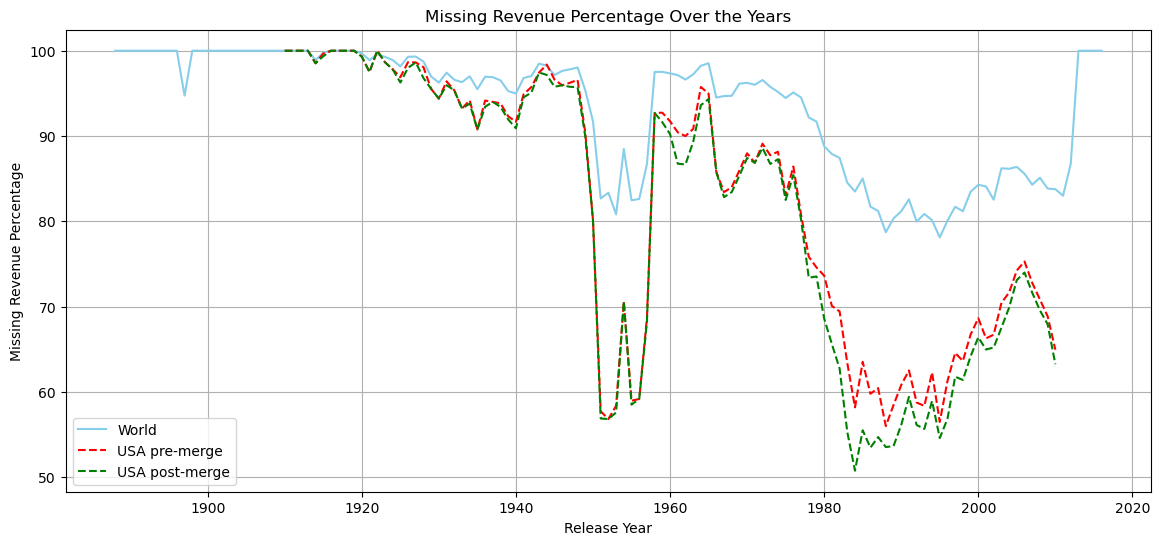

In [47]:
missing_revenue_USA_merge = calculate_missing_percentage(movies2, 'year', 'revenue')

plt.figure(figsize=(14, 6))
plt.plot(missing_revenue_all.index, missing_revenue_all["revenue"], linestyle='-', color='skyblue', label='World')
plt.plot(missing_revenue_USA.index, missing_revenue_USA["revenue"], linestyle='--', color='r', label='USA pre-merge')
plt.plot(missing_revenue_USA_merge.index, missing_revenue_USA_merge["revenue"], linestyle='--', color='g', label='USA post-merge')
plt.xlabel("Release Year")
plt.ylabel("Missing Revenue Percentage")
plt.title("Missing Revenue Percentage Over the Years")
plt.grid()
plt.legend()
plt.show()


It looks better, less data is missing for the revenue !


- Create a dataframe with no missing box office data

In [48]:
movies2_clean = movies2.copy(deep=True)
movies2_clean = movies2.dropna(subset=['revenue']).reset_index(drop=True)

display(movies2_clean.sample(5))
display(movies2_clean.shape)
display(movies2_clean.info())


,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue
5206,13361675,/m/03c2x0z,The Women,2008,114.0,[English Language],[USA],"[Romantic comedy, Romance Film, Drama, Comedy]",4.99818,21096.0,50007546.0
2975,1107088,/m/046kzn,"The Karate Kid, Part II",1986,113.0,[English Language],[USA],"[Action/Adventure, Adventure, Family Drama, Sp...",5.90000,457.0,115103979.0
5854,634114,/m/02p2qpv,Mr. Death: The Rise and Fall of Fred A. Leucht...,1999,91.0,[English Language],[USA],"[Crime Fiction, History, Biography, Law & Crim...",NaN,NaN,507941.0
1600,164359,/m/015wcx,The Buddy Holly Story,1978,113.0,[English Language],[USA],"[Biography, Period piece, Musical, Drama, Biop...",7.50000,33.0,14363400.0
227,17657295,/m/047s7cs,Macon County Line,1974,88.0,[English Language],[USA],"[Crime Fiction, Crime Thriller, Action, Drama,...",NaN,NaN,18800000.0


(6946, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      6946 non-null   int64  
 1   id_freebase  6946 non-null   object 
 2   name         6946 non-null   object 
 3   year         6946 non-null   int32  
 4   runtime      6937 non-null   float64
 5   lang         6946 non-null   object 
 6   countries    6946 non-null   object 
 7   genres       6946 non-null   object 
 8   review       2714 non-null   float64
 9   nbr_review   2714 non-null   float64
 10  revenue      6946 non-null   object 
dtypes: float64(3), int32(1), int64(1), object(6)
memory usage: 569.9+ KB


None

In [49]:
movies2_clean['revenue_part'] = movies2_clean.groupby('year')['revenue'].transform(lambda x: x / x.sum())
 

display(movies2_clean.sample(5))
display(movies2_clean.shape)
display(movies2_clean.info())


,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part
3658,1089071,/m/044_yl,SuperBabies: Baby Geniuses 2,2004,85.0,[English Language],"[USA, United Kingdom, Germany]","[Adventure, Children's/Family, Fantasy, Comedy...",NaN,NaN,9448644.0,0.00056
1564,2452691,/m/07f458,Chaos,2005,74.0,[English Language],[USA],"[B-movie, Horror, Slasher, Teen]",NaN,NaN,20166.0,0.000001
4017,3899170,/m/0b5vtn,36 Hours,1965,115.0,[English Language],[USA],"[Thriller, Drama, War film]",NaN,NaN,2000000.0,0.004495
5415,35723380,/m/0bvmsnv,Man on Fire,1957,95.0,[English Language],[USA],[Drama],NaN,NaN,1750000.0,0.005642
4406,27097,/m/06r2h,Star Trek: First Contact,1996,110.0,[English Language],[USA],"[Thriller, Science Fiction, Action, Time trave...",NaN,NaN,146027888.0,0.015173


(6946, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_wiki       6946 non-null   int64  
 1   id_freebase   6946 non-null   object 
 2   name          6946 non-null   object 
 3   year          6946 non-null   int32  
 4   runtime       6937 non-null   float64
 5   lang          6946 non-null   object 
 6   countries     6946 non-null   object 
 7   genres        6946 non-null   object 
 8   review        2714 non-null   float64
 9   nbr_review    2714 non-null   float64
 10  revenue       6946 non-null   object 
 11  revenue_part  6946 non-null   object 
dtypes: float64(3), int32(1), int64(1), object(7)
memory usage: 624.2+ KB


None

## 0-d) Playing with the data before serious business (first approaches)

In this section, we will provide an example of how we could identify pivotal movies using a relatively simple approach. This part aims to offer insights into the process of recognizing pivotal movies within a dataset.

### i) Analysing a trend: first approach

To effectively identify the 'hype generator,' it's essential to define 'hype' precisely. We have opted to measure hype as the annual percentage change in the production of various movie genres. This approach accounts for the evolving ease of movie production and the resultant increase in the overall number of films produced each year. By focusing on yearly percentage changes, we can effectively neutralize the impact of the growing volume of movie production, ensuring our analysis remains robust and accurate.


Size subset (Teen) 28821


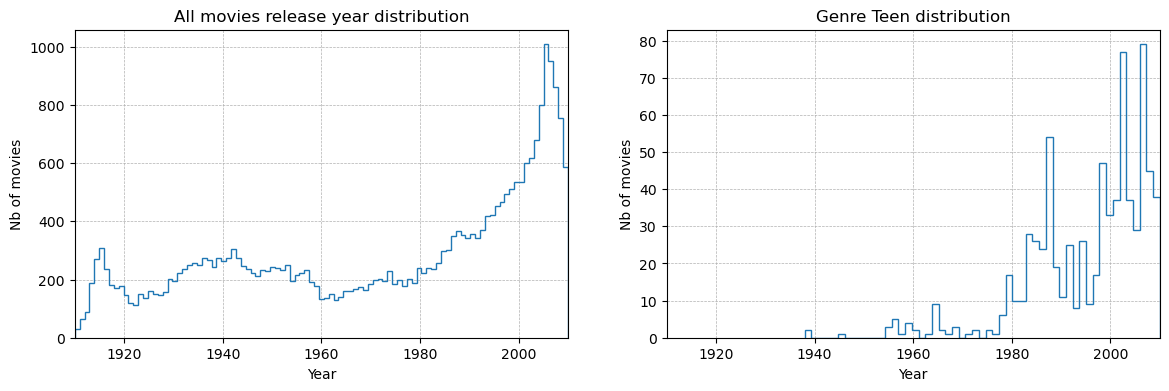

In [50]:
# Create a subset to compare to the whole dataset (here: Teen Movies)
key = 'Teen'
subset = create_subset(movies2, key)
print("Size subset ({}) {}".format(key, len(movies2)))

# Plot release dates distribution
fig, axs = plt.subplots(1, 2, figsize=(14,4))
axs = axs.ravel()

movies.year.hist(bins=movies2.year.nunique(), ax=axs[0], histtype='step')
ax_settings(axs[0], xlabel='Year', ylabel='Nb of movies', title='All movies release year distribution')
axs[0].set_xlim((1910,2010))

subset.year.hist(bins=subset.year.nunique(), ax=axs[1], histtype='step')
ax_settings(axs[1], xlabel='Year', ylabel='Nb of movies', title='Genre {} distribution'.format(key))
axs[1].set_xlim((1910,2010))

plt.show()

This is an early version of the analysis. Here we simply plot the number of movies distribution, but we plan to use the fraction of (subset) movies distribution later for more robust results. However, this already gives us an idea of what we could expect from the data.

We display two graphs above. The left plot is the distribution of movie releases over time. The right plot shows the evolution of number of movies releases over time, of the genre "Teen movie". We immediately notice several elements. First the shapes of the two curves are markedly different, this confirms us that we choose an interesting subset for analysis, since it differs from the baseline. Now by looking more closely, we see that the genre Teen emerged at a certain point in cinema, because (almost) no data exists before late 70's, and we have no record before late 50's. This is very indicating about the existence of a trend ! But we can extract more, we significantly see two bumps in the Teen plot centered around two different decades. Without going much further here, we can already assume that pivotal movies are hiding here...

### ii) Evolution of genre between 1990 and 2012

After this initial example, let's delve deeper into the evolution of 15 genres (ranked in popularity for the considered time range, from 15th place to 30th place) across 30 years of cinema. In this analysis, we shift our focus from the raw number of films released to the percentage relative to the total number of films released each year. This perspective provides a more nuanced understanding of the genre distribution over the years.


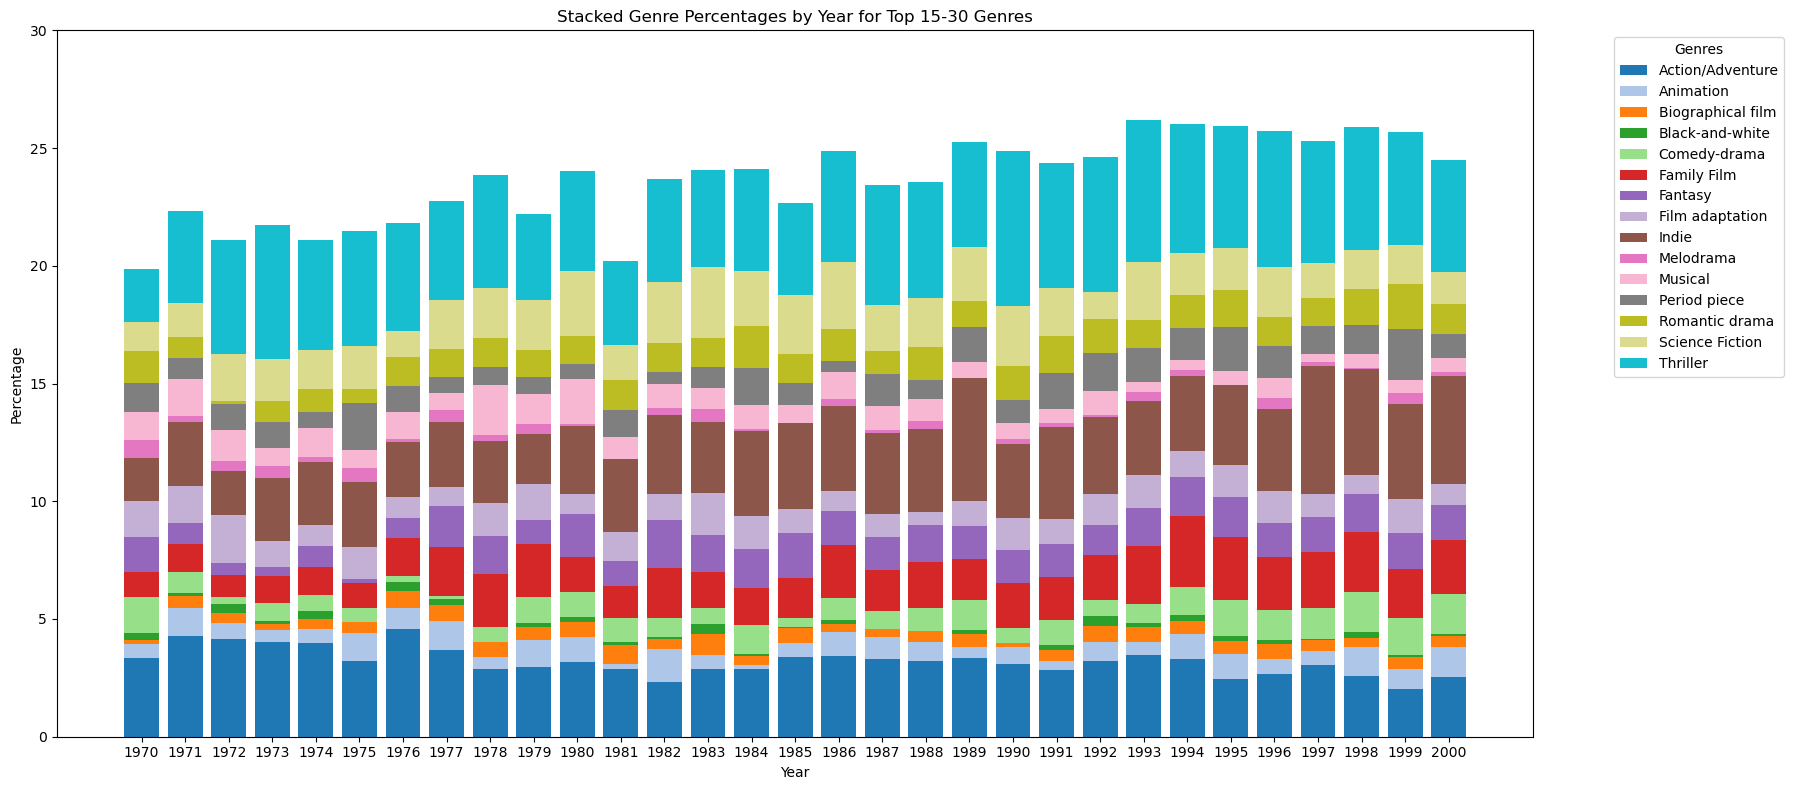

In [51]:
plot_genres_percentages_per_year(movies2, 1970, 2000, 15,30,30)

From the graph above we can for example identify two big varitions in genres 'Biography' in range 1990-1996 and 'Comedy-drama' in range 1978-1983.

We will next focus on identifying the movie that ignited this surge in popularity. By examining films in the pertinent genres and identifying the highest-grossing one in the 5 year prior (based on the assumption that it takes 5 years to produce a movie), we aim to pinpoint the film that was instrumental in boosting the genre's appeal.

- Biography potential hype generator 


In [52]:
biography_film_movies = movies2[movies2['genres'].apply(lambda x: "Biography" in x)] # look for genre: biography film

biography_films_1990_2000 = biography_film_movies[(biography_film_movies['year'] >= 1986)
                                    & (biography_film_movies['year'] <= 1991)]

highest_revenue_movie = biography_films_1990_2000[biography_films_1990_2000['revenue'].notna()].sort_values('revenue', ascending=False).head(4)

display(highest_revenue_movie[["name","year","revenue"]])

,name,year,revenue
22452,JFK,1991,205400000.0
17147,Born on the Fourth of July,1989,196672350.0
26823,The Untouchables,1987,76270454.0
23752,Empire of the Sun,1987,66240000.0


- Comedy drama potential hype generator 


In [53]:
comedy_drama_film_movies = movies2[movies2['genres'].apply(lambda x: "Comedy-drama" in x)] # look for genre: comedy_drama film

comedy_drama_films_1990_2000 = comedy_drama_film_movies[(comedy_drama_film_movies['year'] >= 1973) & (comedy_drama_film_movies['year'] <= 1978)]

highest_revenue_movie = comedy_drama_films_1990_2000[comedy_drama_films_1990_2000['revenue'].notna()].sort_values('revenue', ascending=False).head(4)

display(highest_revenue_movie[["name","year","revenue"]])

,name,year,revenue
2299,American Graffiti,1973,140000000.0
16623,One Flew Over the Cuckoo's Nest,1975,108981275.0
5613,Shampoo,1975,60000000.0
24068,Semi-Tough,1977,37187139.0


In this approach, we identified potential hype generators by looking at films of the same genre that have been released before the trend and generated significant revenues. If we look only at the most revenue generated, the two pivotal movies would be 'JFK' for Biography and 'American Graffiti' for Comedy-drama. However, we see that other movies have a similar order of magnitude of revenue, which hints at the potential limit of this naive approach.


### iii) Identification of the trend by looking at the percentage change
Now we want to automate the process recently done with the art movie in order to predict the hype generators:


We will now identify the genre that experienced the highest percentage change in popularity between 1990 and 2013. A significant change in this percentage is indicative of a 'hype' in the genre, revealing shifts in audience and producers preferences and trends during this period.

We now shift our focus to identifying movies that sparked a surge in popularity. Our approach involves examining films within relevant genres and determining the highest-grossing one in the 5 years prior (considering the assumption that movie production takes 5 years, as stated in the README). The chosen genre for popularity is crucial, as it can impact our analysis. Top genres are often too broad and mainstream, while those at the bottom tend to be too specialized and niche. By selecting this middle range, we aim to strike a balance, capturing genres that are neither overly generic nor excessively niche. In the following case we only take the top 15 to top 30 most 

In [54]:
hype_generators(movies,1990,2013,15,30)

Highest change in percentage by genre between 1990 and  2013 (hype))
 index  year             genres  count  percentage  percentage_change
  8044  1994        Documentary     31    1.726058           0.718506
 10499  2007    Domestic Comedy      7    0.172712           2.575993
 11089  2010              Drama    254   11.179577           0.236074
 11091  2010      Ensemble Film      7    0.308099           2.213468
  8243  1995         Gay Themed      8    0.407332           6.315682
  9112  2000      Gender Issues      4    0.162140           2.794082
  9937  2004            Musical     35    1.157407           0.854424
  9940  2004            Mystery     45    1.488095           0.479885
  7937  1993             Parody     14    0.878845           0.609385
  8278  1995    Political drama     12    0.610998           2.657841
  8447  1996 Political thriller      4    0.206292           3.051573
  8451  1996         Road movie      8    0.412584           1.701049
  9964  2004         

This assessment leads to interesting results such as 'Fantasy' associated with *'The Lord of the Rings: The Return of the King'* or 'Science Fiction' and *'Back to the Future'*. However, some results are rising questions on this naive method. For instance, 'Romance Film' associated to *Star Wars Episode II: Attack of the Clones* demonstrates the limit of the actual naive method. In the future we aim to identify more clearly the principal genre of the movie.

<p align="center">
  <img src="img/StarWars.png" width=70%>

### iv) Trope Originators

Enclosed is a curated selection of seminal films, each marking the inaugural appearance of a particular trope. These films are esteemed as pivotal within the cinematic world, as they present audiences with the archetype of a character type for the very first time, setting the stage for countless others to follow it.
(Disclaimer: it is from the uncomplete trope dataset, from the course given data). 

In [55]:
summaries, characters, tvtropes, movies_initial_subset = get_initial_data(MOVIES_FOLDER)
trope_originators(tvtropes, movies_initial_subset)

,category,name,date
3,absent_minded_professor,Them!,1954-06-16
6,adventurer_archaeologist,Indiana Jones and the Raiders of the Lost Ark,1981-06-12
14,arrogant_kungfu_guy,Rocky,1976-11-21
26,big_man_on_campus,Can't Hardly Wait,1998-06-12
28,bounty_hunter,The Outlaw Josey Wales,1976-06-30
45,brainless_beauty,Roxanne,1987-06-19
52,broken_bird,Alice in Wonderland,1976-12-10
58,bromantic_foil,Mallrats,1995-10-20
63,bruiser_with_a_soft_center,Casino Royale,1967-01-01
66,bully,A Christmas Story,1983-11-18


# 1) Finding Potential pivotal movies

In this section, we will first analyze trends in specific genres of movies, focusing on those that are more niche and specific, such as Science Fiction, Teen, and Biography. The objective is to uncover patterns and insights within these specialized genres, as opposed to broader categories like Action or Adventure. We need to be careful to not choosing genre that are too niche because the set of movie will be too small to be analysed. 

After obtaining the trends we could be able to identify, for each trend, a subset of movies that could have strat the trend (i.e. pivotal movies)

## 1-a) Selection of subsets by genre

In [56]:
subsets = select_subsets(movies)
print('Number of subsets: {}'.format(len(subsets)))

Number of subsets: 244


In [57]:
subsets_double = select_subsets_double(subsets)
print('Number of subsets double: {}'.format(len(subsets_double)))

Number of subsets double: 424


## 1-b) Trend graphs for some genres


Subset: Horror
	2571 | 28821 (size subset | movies)
	= 8.9206 %


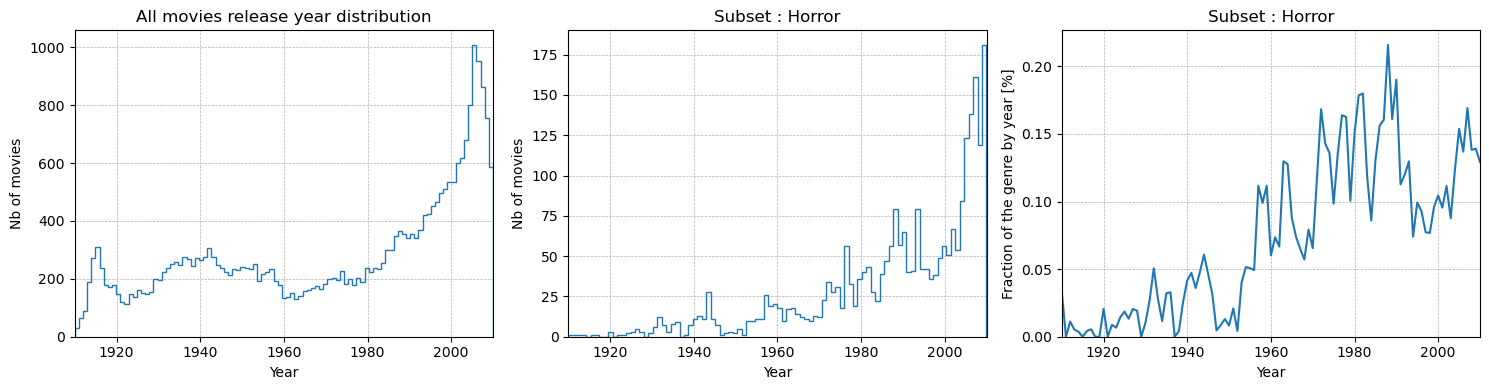

In [58]:
# VISUALIZE SUBSET i
i = find_subset(subsets, 'Horror')
viz_subset(i, subsets, movies)

Subset: ('Action', 'Adventure')
	1150 | 28821 (size subset | movies)
	= 3.9901 %


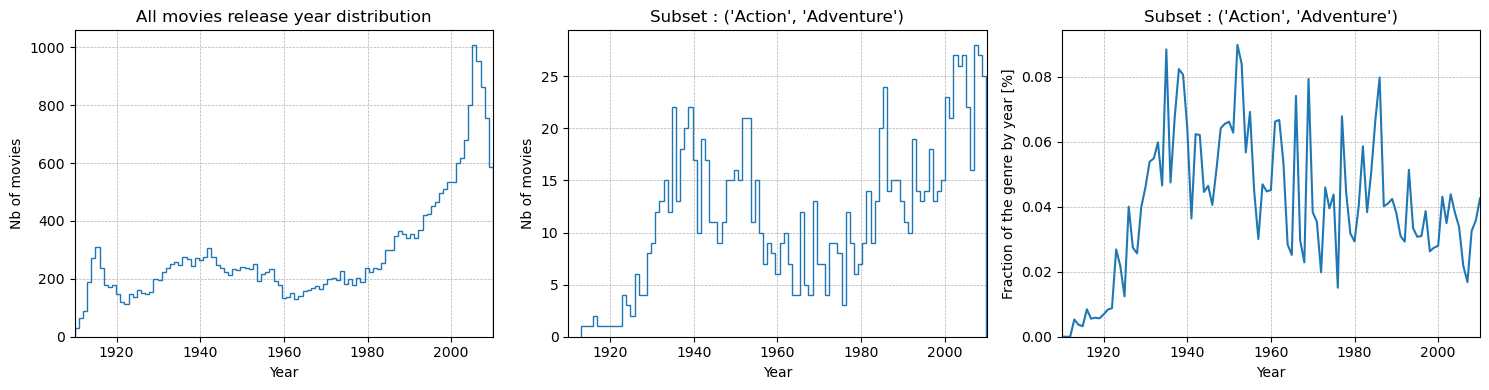

In [59]:
# VISUALIZE SUBSET DOUBLE i
i = find_subset_double(subsets_double, 'Adventure', 'Action')
viz_subset(i, subsets_double, movies)

## 1-c) Trend automatic detection

In [60]:
QUALITY = 0.2
trends = get_trends(movies, subsets, QUALITY)
trends_double = get_trends(movies, subsets_double, QUALITY)

print('Nb of trends single genre: {}'.format(len(trends)))
print('trends = ("genre_name", [peak_years], [inflexion_years], [peak_quality])\n')
print('Trend detection for first subset:')
display(trends[0])
print('\nNb of trends double genre: {}'.format(len(trends_double)))
print('Trend detection for first subset double:')
display(trends_double[0])

Nb of trends single genre: 244
trends = ("genre_name", [peak_years], [inflexion_years], [peak_quality])

Trend detection for first subset:


('Absurdism',
 [1977, 1995],
 [1965, 1990],
 [1.3270890045169648, 0.21340208046825065])


Nb of trends double genre: 424
Trend detection for first subset double:


(('Action', 'Action Thrillers'),
 [1975, 1996],
 [1967, 1988],
 [0.693707685046017, 0.4127668978845666])

======== Subset Animation ========
Peaks: 		  [1937, 1955, 2006]
Inflexion points: [1928, 1949, 1997]
Quality of peaks: [0.8944550792731196, 0.10797647002213683, 0.2703500979062737]


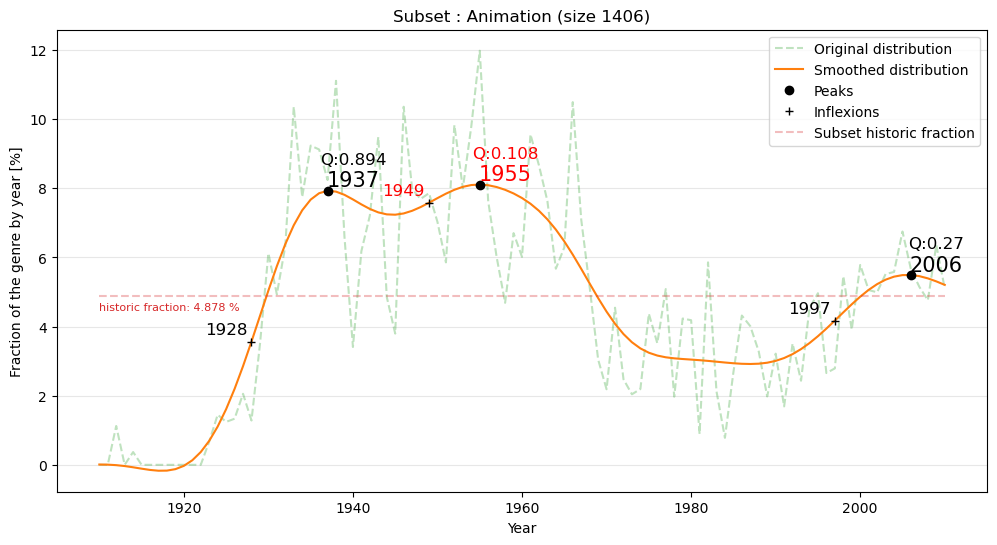

In [61]:
# Visualize trend detection for subset i
i = find_subset(subsets, 'Animation')

print('======== Subset {} ========'.format(subsets[i][0]))
print('Peaks: \t\t  {}'.format(get_peaks(movies, subsets, i)[0]))
print('Inflexion points: {}'.format(get_peaks(movies, subsets, i)[1]))
print('Quality of peaks: {}'.format(get_peaks(movies, subsets, i)[2]))

fig = viz_peaks(movies, subsets, i)

======== Subset Double ('Action', 'Adventure') ========
Peaks: 		  [1937, 1952, 1985]
Inflexion points: [1928, 1948, 1979]
Quality of peaks: [0.6602947805607252, 0.048789334908421925, 0.13791540152232784]


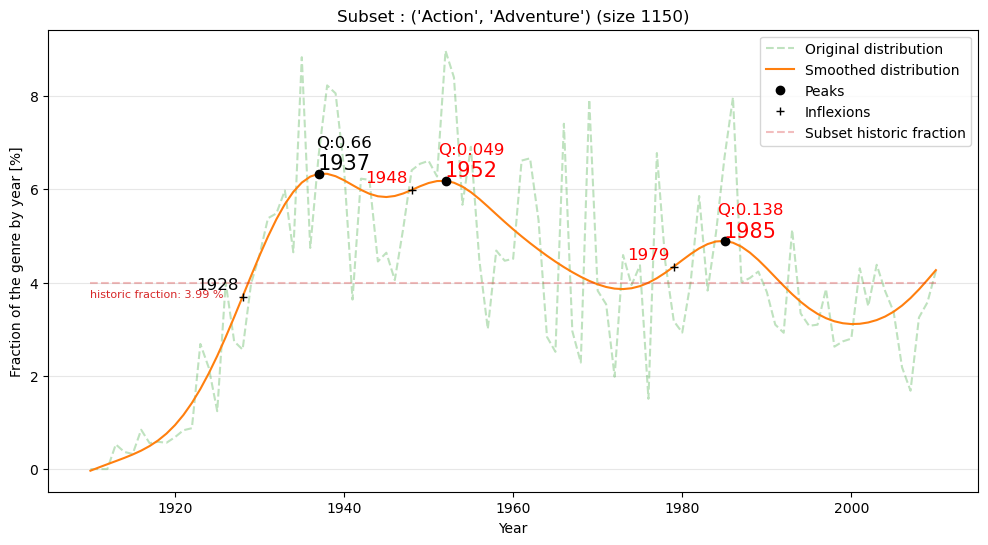

In [62]:
# Visualize trend detection for subset double i
i = find_subset_double(subsets_double, 'Adventure', 'Action')

print('======== Subset Double {} ========'.format(subsets_double[i][0]))
print('Peaks: \t\t  {}'.format(get_peaks(movies, subsets_double, i)[0]))
print('Inflexion points: {}'.format(get_peaks(movies, subsets_double, i)[1]))
print('Quality of peaks: {}'.format(get_peaks(movies, subsets_double, i)[2]))

fig = viz_peaks(movies, subsets_double, i)

#### Save all trends visualizations as images

In [63]:
# Run this cell to download all trend plots (6min)
# get_all_viz(movies, subsets)

## 1-d) Construction of potential pivotal movie sets 
 

In [64]:
candidates = get_candidates(subsets, trends)
candidates_double = get_candidates_double(subsets_double, trends_double)
print('Nb of sets of candidates: {}'.format(len(candidates)))
print('Nb of sets of candidates double: {}'.format(len(candidates_double)))

Nb of sets of candidates: 387
Nb of sets of candidates double: 628


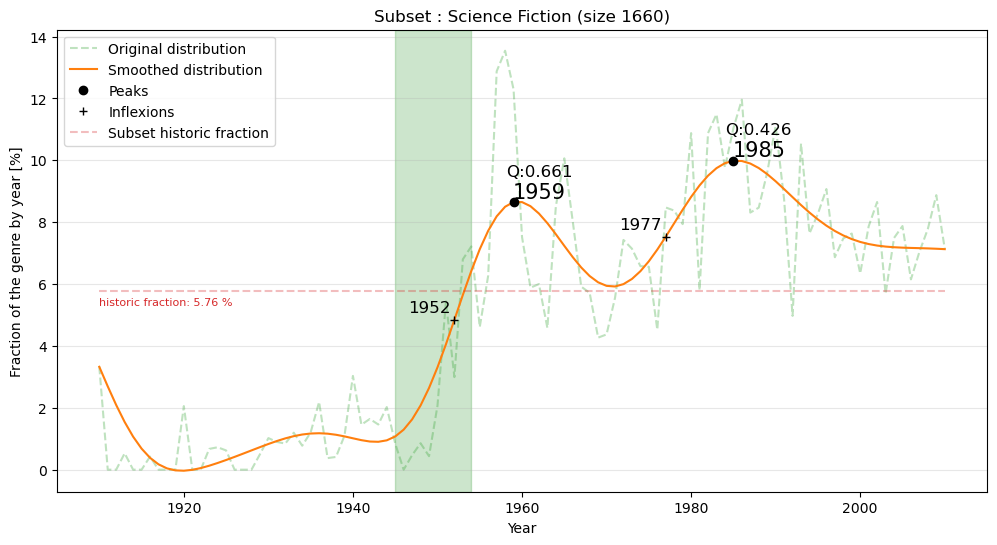

Candidates of pivotal of genre Science Fiction, for trend peak in 1959 and trend inflexion in 1952
Nb of candidates: 62


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
37427,14143898,/m/03cvyvb,The Monster and the Ape,1945,NaN,NaN,[English Language],[USA],"[Science Fiction, Sci-Fi Adventure, Adventure,..."
46748,8279491,/m/026ytcn,The Purple Monster Strikes,1945,NaN,NaN,[English Language],[USA],"[Science Fiction, Action, Adventure, Black-and..."
51709,11457604,/m/02rdfgc,Brick Bradford,1947,NaN,NaN,[English Language],[USA],"[Science Fiction, Action, Adventure, Black-and..."
32589,28387767,/m/0crgyyh,Unknown Island,1948,NaN,75.0,[English Language],[USA],"[Science Fiction, Action, Adventure]"
13194,6680124,/m/0gg_ry,Haredevil Hare,1948,NaN,NaN,[English Language],[USA],"[Short Film, Science Fiction, Family Film, Com..."
...,...,...,...,...,...,...,...,...,...
54770,6720101,/m/0gkfdj,Crash of Moons,1954,NaN,78.0,[English Language],[USA],"[Science Fiction, Indie, Black-and-white, Adve..."
16483,5609683,/m/0dw35q,The Snow Creature,1954,NaN,69.0,[English Language],[USA],"[Science Fiction, Horror, Creature Film]"
26322,72317,/m/0jhpk,Creature from the Black Lagoon,1954,1300000.0,80.0,[English Language],[USA],"[Monster movie, Science Fiction, Horror, Adven..."
25271,5516824,/m/0dqg_9,"20,000 Leagues Under the Sea",1954,11267000.0,122.0,[English Language],[USA],"[Science Fiction, Adventure, Action/Adventure,..."


In [65]:
show_candidates(movies, subsets, candidates, 'Science Fiction', peak='first')

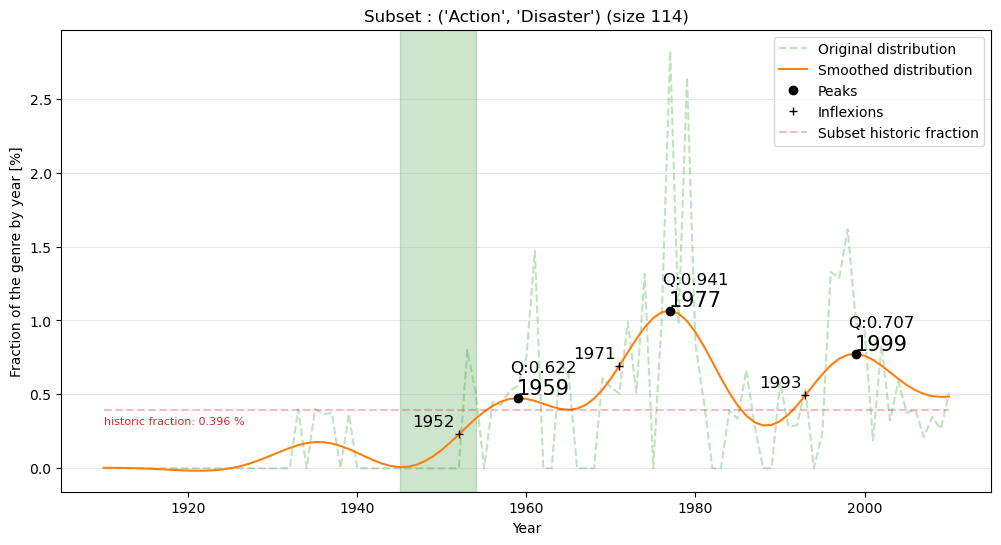

Candidates of pivotal of genre ('Action', 'Disaster'), for trend peak in 1959 and trend inflexion in 1952
Nb of candidates: 3


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
73233,1203778,/m/04h14p,Titanic,1953,2250000.0,103.0,[English Language],[USA],"[Black-and-white, Action/Adventure, Drama, Dis..."
74219,3626936,/m/09qvsz,Island in the Sky,1953,2750000.0,109.0,[English Language],[USA],"[Disaster, Action/Adventure, Action, Drama, Ad..."
29740,1591858,/m/05d_r6,The High and the Mighty,1954,8500000.0,148.0,[English Language],[USA],"[Adventure, Action/Adventure, Drama, Disaster,..."


In [66]:
show_candidates_double(movies, subsets_double, candidates_double, 'Action', 'Disaster', peak='first')

# 2) Metric assessment for Pivotal Movies identification

Identifying the pivotal movie, or the one that starts a trend, involves a combination of qualitative and quantitative analysis. Here are considerations and steps to help define the chosen pivotal movie within a specific genre:

- **Box-office Revenue :**
    Analyze the box-office performance of candidate movies within the subset. The pivotal movie often exhibits exceptional financial success, indicating a strong audience demand for the particular genre or theme. We need then to look for movies that surpassed industry expectations in terms of revenue. Also comparing the box-office performance of candidate movies to industry standards and consider their impact on subsequent films' budgeting and revenue expectations.

- **Reviews :**
   Critical reception is a key indicator of a movie's impact and lasting influence. The pivotal movie should have received positive reviews from both critics and audiences, showcasing its quality and appeal. To this aims we incorporate a new dataset that includes review. These review will be a measuremnent of how good a movie is . This metric is fundamental to identify the pivotal movie : if a film is considered as bad there is no chance that it influence the cinema industry and creating a trend.

- **Awards :**
Another measure for assessing influence is the recognition garnered through awards. Industry accolades serve as a validation of a movie's cultural and artistic significance. The receipt of awards signifies not only the excellence of the film but also its potential to set a standard worth emulating. It provides more precise insights into why the film is esteemed. Noteworthy awards include prestigious honors like the Oscars. In our analysis, we have opted to incorporate a dataset that encompasses these awards and their respective categories.

- **Plot Similarity:**
  This metric serves as an assessment of the extent to which a film influences others within the genre during trends. The concept is as follows: if the plot of a potential pivotal film closely resembles those observed in subsequent trend films when compared to other movies in the candidate subset, it indicates the film's influence on plot development. This similarity suggests that other films intentionally emulated the storyline, signifying the impactful nature of the pivotal film.



All these metrics will be exploited to select the pivotal film among the candidate subset. But to use it we need to properly define function which calculate from available data or simply add missing data from other dataset.


In [67]:
# MEHDI: les trucs intéressants de further cleaning
# A box office revenue
# B reviews
# C awards
# D plot similarity

# 3) Machine Learning

# 4) Pivotal Movies

In [68]:
pivotals_list = most_likely_pivotal # pour prendre la liste de Paul, générée en Machine Learning

NameError: name 'most_likely_pivotal' is not defined

In [ ]:
pivotals_of_genres = get_pivotals_of_genres(pivotals_list)

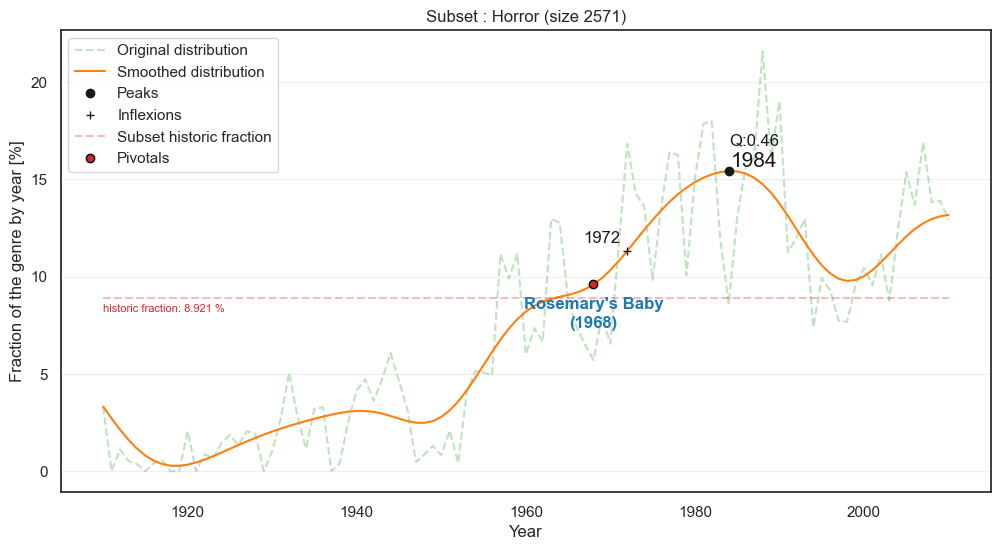

In [ ]:
pivotals_i = get_pivotals(movies, subsets, pivotals_list, pivotals_of_genres, 'Horror', show=True)

In [ ]:
show_pivotal(pivotals_list, candidates, 1)
show_pivotal(pivotals_list, candidates, 2)

==== PIVOTAL MOVIE ====
For genre Absurdism of the trend peak 1995
	🏆🏆 >> PIVOTAL IS Spaceballs (1987)
		(Quality TBD)

==== PIVOTAL MOVIE ====
For genre Action of the trend peak 1974
	🏆🏆 >> PIVOTAL IS Lawrence of Arabia (1962)
		(Quality TBD)



#### Save all pivotals visualizations as images

In [ ]:
# Run this cell to download all pivotal plots
# get_all_viz_pivotal(movies, subsets, pivotals_list, pivotals_of_genres)

# 5) Pivotal Analysis

In [ ]:
# PAUL: network

In [ ]:
# MEHDI: pivotals description

--------------------------------------------------------------------------------------------------------------------------------

## Further cleaning and data gathering

In [69]:
# Start with the pre-merge df of Milestone 2:

display(movies.sample(5))
display(movies.shape)
display(movies.info())
generate_missing_info(movies)

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
39790,4453691,/m/0c38gj,Blood Diamond,2006,171407179.0,138.0,"[Afrikaans Language, Mende Language, English L...","[USA, Germany]","[Crime Fiction, Thriller, Tragedy, Adventure, ..."
892,31707381,/m/09kjprg,The Way to the Gold,1957,2900000.0,94.0,[English Language],[USA],"[Drama, Adventure]"
59503,14916202,/m/03h1dms,Ashanti,1979,NaN,118.0,[English Language],[USA],"[Action/Adventure, Action, Drama, Adventure, F..."
30820,8928152,/m/027q0mq,Because of Winn-Dixie,2005,33589527.0,106.0,[English Language],[USA],"[Family Drama, Comedy-drama, Children's, Drama..."
45208,16675752,/m/03ylyqz,She's No Angel,2001,NaN,90.0,[English Language],[USA],"[Thriller, Drama, Television movie]"


(28821, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 28821 entries, 0 to 74827
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  float64
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 2.1+ MB


None

,Missing Data (%)
Column,
id_wiki,0.00
id_freebase,0.00
name,0.00
year,0.00
revenue,77.56
runtime,10.79
lang,0.00
countries,0.00
genres,0.00


### Cleaning big IMDB dataset

In [70]:
# Loading big IMDb dataset
IMDB_PATH = '/imdb_ratings_all_time/movies_imdb.csv'

imdb_vanilla = pd.read_csv(DATA_PATH+IMDB_PATH, usecols=['id', 'name', 'year', 'rating', 'duration', 'votes', 'gross_income'], low_memory=False)

display(imdb_vanilla.sample(5))
display(imdb_vanilla.shape)
display(imdb_vanilla.info())
display(imdb_vanilla.isnull().sum())
display(imdb_vanilla[imdb_vanilla['gross_income']!='0'].sample(5))

,id,name,year,rating,duration,votes,gross_income
2286045,tt17074078,Der Club,(1985– ),11.0,0 min,0,0
1242642,tt1679976,Rainbow,(1972–1992),11.0,0 min,0,0
2058931,tt15563616,Dwarfina,(2011– ),11.0,0 min,0,0
2577965,tt8580142,Running Man,(2010– ),11.0,90 min,0,0
1530313,tt10184456,Yeni Gelin,(2017–2018),11.0,0 min,0,0


(2590932, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590932 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 138.4+ MB


None

id              0
name            4
year            0
rating          0
duration        0
votes           0
gross_income    0
dtype: int64

,id,name,year,rating,duration,votes,gross_income
2086313,tt5057140,Hold the Dark,(2018),5.6,125 min,"37,014","54,760,791"
835638,tt1426374,Los viajes del viento,(2009),7.4,117 min,"2,389","19,161,363"
2142911,tt0068969,Morbo,(1972),5.7,88 min,166,"132,863"
11639,tt8180060,The Grifter,(2009 Video),3.9,"1,440 min",15,"3,077"
833848,tt0022551,Way Back Home,(1931),5.7,81 min,829,21


In [71]:
imdb = imdb_vanilla.copy(deep=True)

# Let's get rid of the missing movie names
imdb = imdb_vanilla.loc[~imdb_vanilla.name.isnull()]

# Cleaning the year column: removing some characters and extracting starting year only
imdb = imdb[~imdb['year'].astype(str).str.contains('-|–')]
imdb.loc[:, 'year'] = imdb['year'].str.extract(r'(\d+)', expand=False)
imdb['year'] = imdb['year'].replace('', np.nan)
imdb['year'] = pd.to_numeric(imdb['year'], errors='coerce')
imdb.loc[:, 'year'] = imdb['year'].astype('Int64', errors='ignore')

# Dataframe is huge, and we do not care about movies post-2017: let's reduce it a bit
imdb = imdb[imdb['year'] <= 2017].reset_index(drop=True)

# From gross income, remove undesired characters and turn to float:
imdb.loc[:, 'gross_income'] = imdb['gross_income'].apply(lambda x: clean_gross_income(x))
imdb['gross_income'] = pd.to_numeric(imdb['gross_income'], errors='coerce')
imdb.loc[:, 'gross_income'] = imdb['gross_income'].replace(0, np.nan)

# From votes, remove undesired characters and turn to float:
imdb.loc[:, 'votes'] = imdb['votes'].str.replace(',', '').astype(float)
imdb.loc[:, 'votes'] = imdb['votes'].replace(0, np.nan)
imdb.loc[pd.isna(imdb['votes']), 'rating'] = np.nan
imdb = imdb[imdb['rating'] <= 10]

# Extract number from duration:
imdb.loc[:, 'duration'] = imdb['duration'].str.extract(r'(\d+)', expand=False)
imdb.loc[:,'duration'] = imdb['duration'].astype(float)
imdb.loc[:, 'duration'] = imdb['duration'].replace(0, np.nan)
imdb['duration'] = pd.to_numeric(imdb['duration'], errors='coerce')  

# Year and duration are elements used to detect and fuse duplicates: need them clean
imdb = imdb.dropna(subset=['year', 'duration'])

# If both votes and gross_income are unknown, then the row is of no use
imdb = imdb.dropna(subset=['votes', 'gross_income'], how='all').reset_index(drop=True)

display(imdb[~(imdb['gross_income'].isna())!=0].sample(5))
display(imdb.shape)
display(imdb.info())
generate_missing_info(imdb)

,id,name,year,rating,duration,votes,gross_income
71147,tt1180583,Vaaranam Aayiram,2008,8.2,169.0,12828.0,602500.0
107594,tt1232047,"Ed, Edd n Eddy's Big Picture Show",2009,8.2,87.0,2802.0,2013193.0
29387,tt0119891,Phantoms,1998,5.4,96.0,20977.0,5657370.0
86306,tt2568472,Mercedes Sosa: The Voice of Latin America,2013,7.1,90.0,113.0,2346.0
148274,tt1376213,The Adventurer: The Curse of the Midas Box,2013,5.4,100.0,6712.0,1004756.0


(214143, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214143 entries, 0 to 214142
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            214143 non-null  object 
 1   name          214143 non-null  object 
 2   year          214143 non-null  Int64  
 3   rating        214143 non-null  float64
 4   duration      214143 non-null  float64
 5   votes         214143 non-null  object 
 6   gross_income  27935 non-null   float64
dtypes: Int64(1), float64(3), object(3)
memory usage: 11.6+ MB


None

,Missing Data (%)
Column,
id,0.00
name,0.00
year,0.00
rating,0.00
duration,0.00
votes,0.00
gross_income,86.95


In [72]:
# Are there any doublons ?
display(check_doublons(imdb, col_check=['name'], year='year', runtime='duration'))

# Example of a doublon 
display(imdb[(imdb['name']=='Unconditional') & (imdb['year']==2012)]) 

Rows with real duplicates: 
                              name  year  duration
3134                 Unconditional  2012      92.0
4210                   Blood Money  2012     109.0
12047   The Game Ain't 4 Everybody  2009     105.0
13546                      Misfits  2015      20.0
14199          Trouble in Paradise  1989     100.0
...                            ...   ...       ...
214138                   Game Face  2017      42.0
214139                   Game Face  2017      42.0
214140                   Game Face  2017      42.0
214141                   Game Face  2017      42.0
214142                   Game Face  2017      42.0

[10243 rows x 3 columns]


'--------------------------------------------------------------------------------'

,id,name,year,rating,duration,votes,gross_income
3134,tt1758610,Unconditional,2012,7.0,92.0,4800.0,1005800.0
199175,tt1967651,Unconditional,2012,6.5,92.0,741.0,NaN


In [73]:
# Need to fuse the duplicates
imdb_clean = imdb.copy(deep=True)

imdb_clean = fuse_duplicates_imdb(imdb_clean)
imdb_clean = calculate_weighted_average(imdb_clean, 'name', 'rating', 'votes')

# Merge successful ?
display(imdb_clean[(imdb_clean['name']=='Unconditional') & (imdb_clean['year']==2012)]) 
display(check_doublons(imdb_clean, col_check=['name'], year='year', runtime='duration'))
# Yes !

display(imdb_clean.sample(5))
display(imdb_clean.shape)
display(imdb_clean.info())

,id,name,year,rating,duration,votes,gross_income
3134,tt1758610,Unconditional,2012,6.9,92.0,5541.0,1005800.0


No duplicates


'--------------------------------------------------------------------------------'

,id,name,year,rating,duration,votes,gross_income
175942,tt0085041,Just Our Luck,1983,7.9,30.0,39.0,NaN
147566,tt0978764,Sucker Punch,2011,6.0,110.0,241818.0,36392502.0
194407,tt6804022,Da jiao niang zi,1977,5.8,104.0,6.0,NaN
85279,tt0114667,Tie-died: Rock 'n Roll's Most Deadicated Fans,1995,6.2,80.0,72.0,146603.0
76842,tt0346113,Public Jitterbug No. 1,1939,5.7,21.0,101.0,NaN


(205729, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 205729 entries, 0 to 214136
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            205729 non-null  object 
 1   name          205729 non-null  object 
 2   year          205729 non-null  Int64  
 3   rating        205729 non-null  float64
 4   duration      205729 non-null  float64
 5   votes         205729 non-null  float64
 6   gross_income  27934 non-null   float64
dtypes: Int64(1), float64(4), object(2)
memory usage: 12.8+ MB


None

### Original name map

In [74]:
NAME_MAP_PATH = '/imdb_ratings_all_time/imdb_title_map.tsv'

name_map_vanilla = pd.read_csv(DATA_PATH+NAME_MAP_PATH, sep='\t', usecols=['tconst', 'primaryTitle', 'originalTitle', 'startYear', 'runtimeMinutes']).rename(columns={'originalTitle': 'name',
                                                                                                                                                        'startYear': 'year',
                                                                                                                                                        'runtimeMinutes': 'duration'})

display(name_map_vanilla.sample(5))
display(name_map_vanilla.shape)
display(name_map_vanilla.info())

,tconst,primaryTitle,name,year,duration
4327655,tt16266760,Pouting Thoughts,Pouting Thoughts,2021,\N
5658567,tt22018792,Yeah... Bad Batch 2 Coming 2023... Mandalorian...,Yeah... Bad Batch 2 Coming 2023... Mandalorian...,2022,\N
9211806,tt7344050,Episode #13.237,Episode #13.237,2017,\N
6536118,tt27469319,The Virgin Story,The Virgin Story,2022,\N
409218,tt0426631,Wrath Unleashed,Wrath Unleashed,2004,\N


(9387091, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9387091 entries, 0 to 9387090
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   tconst        object
 1   primaryTitle  object
 2   name          object
 3   year          object
 4   duration      object
dtypes: object(5)
memory usage: 358.1+ MB


None

In [75]:
# This dataframe is the key to overcome the "Star Wars" problem
# (ie: nomenclature changes for same movie across dataframes)

display(name_map_vanilla[name_map_vanilla['name']=='Star Wars'].head(1))
display(imdb_clean[imdb_clean['name']=='Star Wars'])
display(movies[movies['name'].str.contains('Star Wars Episode VI: Return of the Jedi')])

,tconst,primaryTitle,name,year,duration
75141,tt0076759,Star Wars: Episode IV - A New Hope,Star Wars,1977,121


,id,name,year,rating,duration,votes,gross_income
147390,tt0076759,Star Wars,1977,8.6,121.0,1332366.0,322740140.0


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
14376,50744,/m/0ddjy,Star Wars Episode VI: Return of the Jedi,1983,475106177.0,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."


In [76]:
# Extract duration in minutes
name_map_vanilla['duration'] = name_map_vanilla['duration'].str.extract('(\d+\.\d+|\d+)').astype(float)
# If there are non-numeric values, replace them with np.nan
name_map_vanilla['duration'] = name_map_vanilla['duration'].replace('', np.nan)

# Extract year
name_map_vanilla['year'] = name_map_vanilla['year'].str.extract('(\d+)').astype(float)
# If there are non-numeric values, replace them with np.nan
name_map_vanilla['year'] = name_map_vanilla['year'].replace('', np.nan)
name_map_vanilla.loc[:, 'year'] = name_map_vanilla['year'].astype('Int64', errors='ignore')

# Get rid of missing data in duration and year
name_map = name_map_vanilla.copy(deep=True)
name_map = name_map_vanilla.dropna(subset=['duration', 'year']).reset_index(drop=True)

display(name_map.sample(5))
display(name_map.info())
generate_missing_info(name_map)


,tconst,primaryTitle,name,year,duration
1987408,tt3184892,Against All Odds,Against All Odds,2010,60.0
2007733,tt3314488,One Minute for Conductors,One Minute for Conductors,2013,87.0
739345,tt1148471,Twinkle's Favorite Author/Don't Fence Me In,Twinkle's Favorite Author/Don't Fence Me In,2005,30.0
250859,tt0362338,Comic Relief Does Fame Academy,Comic Relief Does Fame Academy,2003,60.0
2293693,tt5238740,Stalker,Stalker,2015,16.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644199 entries, 0 to 2644198
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   tconst        object 
 1   primaryTitle  object 
 2   name          object 
 3   year          Int64  
 4   duration      float64
dtypes: Int64(1), float64(1), object(3)
memory usage: 103.4+ MB


None

,Missing Data (%)
Column,
tconst,0.0
primaryTitle,0.0
name,0.0
year,0.0
duration,0.0


In [77]:
# Are there any doublons ?
display(check_doublons(name_map, col_check=['name'], year='year', runtime='duration'))

# If that's the case let's drop the doublons
name_map_clean = drop_duplicates(name_map, col_check=['name', 'year', 'duration'])

display(check_doublons(name_map_clean, col_check=['name'], year='year', runtime='duration'))
display(name_map_clean.info())

Rows with real duplicates: 
                           name  year  duration
103      The Kiss in the Tunnel  1899       1.0
1262      Bread Upon the Waters  1913      11.0
1334          The Doctor's Duty  1913      11.0
1385                 Flood Tide  1913      11.0
1480                  The Idler  1914      11.0
...                         ...   ...       ...
2644083           Episode #1.10  2017      55.0
2644084            Episode #1.3  2017      55.0
2644129                  Broken  2017       4.0
2644167               Avsnitt 3  2017      44.0
2644168               Avsnitt 4  2017      45.0

[178245 rows x 3 columns]


'--------------------------------------------------------------------------------'

No duplicates


'--------------------------------------------------------------------------------'

<class 'pandas.core.frame.DataFrame'>
Index: 2526746 entries, 0 to 2644198
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   tconst        object 
 1   primaryTitle  object 
 2   name          object 
 3   year          Int64  
 4   duration      float64
dtypes: Int64(1), float64(1), object(3)
memory usage: 118.1+ MB


None

### IMDB MERGE

In [78]:
# Merging imdb_clean and name_map_clean to obtain the final IMDb dataframe
imdb_final = pd.merge(name_map_clean, imdb_clean, on=['name', 'year', 'duration'], how='right').drop(columns={'tconst', 'id'}).rename(columns={'primaryTitle': 'alt_name',
                                                                                                                                                'duration': 'runtime', 
                                                                                                                                                'gross_income': 'revenue'})

display(imdb_final.sample(5))
display(imdb_final.shape)
display(imdb_final.info())
generate_missing_info(imdb_final)

# The "Star Wars" problem is taken care of
display(imdb_final[imdb_final['name']=='Star Wars'])

,alt_name,name,year,runtime,rating,votes,revenue
150099,Doroga,Doroga,2013,22.0,7.2,42.0,NaN
33510,NaN,Wolf Guy,1975,86.0,6.3,946.0,NaN
199268,Behind,Behind,2005,3.0,8.5,35.0,NaN
7031,Terror on Tour,Terror on Tour,1980,87.0,3.8,380.0,59440.0
48,Man on Fire,Man on Fire,2004,146.0,7.7,358248.0,77911774.0


(205729, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205729 entries, 0 to 205728
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alt_name  158007 non-null  object 
 1   name      205729 non-null  object 
 2   year      205729 non-null  Int64  
 3   runtime   205729 non-null  float64
 4   rating    205729 non-null  float64
 5   votes     205729 non-null  float64
 6   revenue   27934 non-null   float64
dtypes: Int64(1), float64(4), object(2)
memory usage: 11.2+ MB


None

,alt_name,name,year,runtime,rating,votes,revenue
141635,Star Wars: Episode IV - A New Hope,Star Wars,1977,121.0,8.6,1332366.0,322740140.0


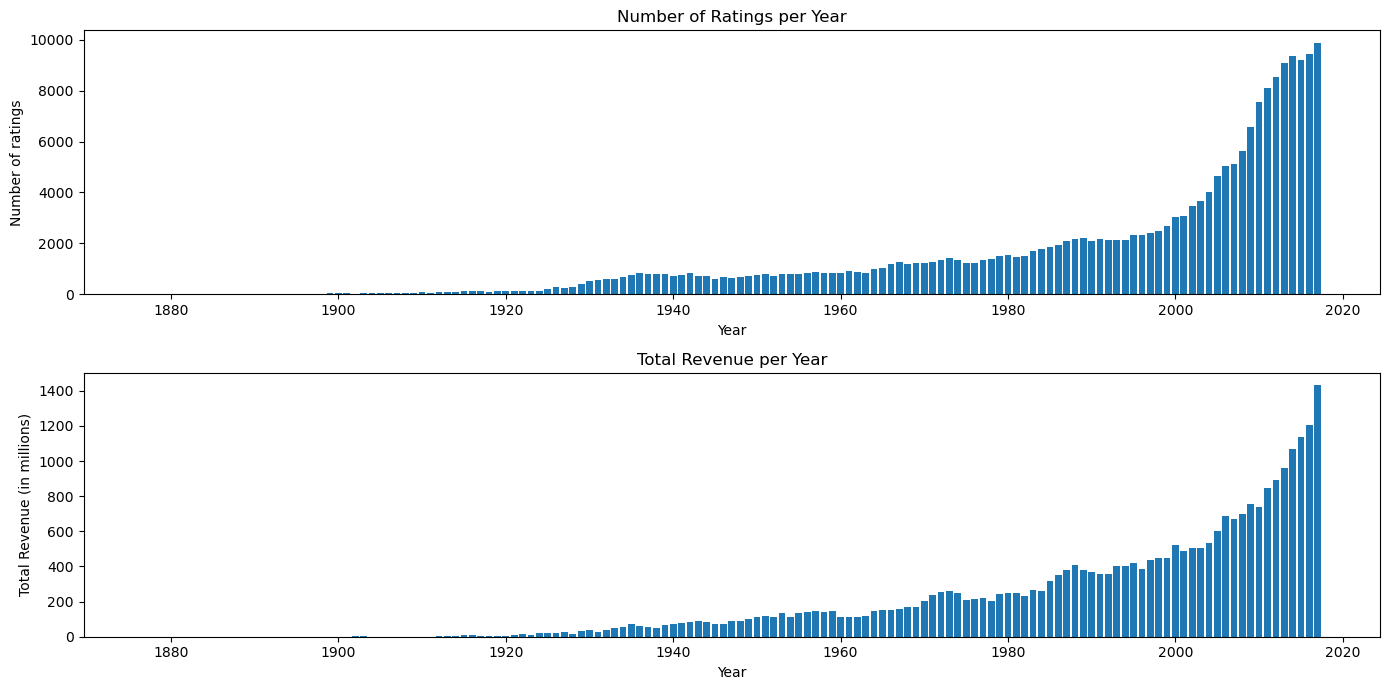

In [79]:
# Let's check the yearly distribution of ratings and revenues in the imdb_final dataframe
revenue_per_year_imdb = imdb_final.groupby('year')['revenue'].count().reset_index()
reviews_count_per_year_imdb = imdb_final.groupby('year')['rating'].count().reset_index()

fig = plt.figure(figsize=(14, 7))

# Plot for number of ratings per year
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.bar(reviews_count_per_year_imdb['year'], reviews_count_per_year_imdb['rating'])
plt.xlabel('Year')
plt.ylabel('Number of ratings')
plt.title('Number of Ratings per Year')

# Plot for revenue per year
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.bar(revenue_per_year_imdb['year'], revenue_per_year_imdb['revenue'])
plt.xlabel('Year')
plt.ylabel('Total Revenue (in millions)')
plt.title('Total Revenue per Year')

plt.tight_layout()
plt.show()

In [80]:
# To make it ready for future merges: clean the names to get rid of some characters and trailing white spaces
imdb_final['alt_name'] = imdb_final['alt_name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
imdb_final['alt_name'] = imdb_final['alt_name'].str.replace('\s+', ' ', regex=True).str.strip()
imdb_final['name'] = imdb_final['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
imdb_final['name'] = imdb_final['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(imdb_final[imdb_final['name']=='Star Wars'])

,alt_name,name,year,runtime,rating,votes,revenue
141635,Star Wars Episode IV A New Hope,Star Wars,1977,121.0,8.6,1332366.0,322740140.0


### IMDB_FINAL & MOVIELENS MERGE

In [81]:
# Loading the cleaned movie_lens dataframe from Milestone 2
movies_lens = movies_lens.rename(columns={'review': 'rating', 'nbr_review': 'votes'})

# To make it ready for future merges: clean the names to get rid of some characters and trailing white spaces

movies_lens['name'] = movies_lens['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
movies_lens['name'] = movies_lens['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())

,revenue,runtime,name,rating,votes,year
3041,23563727.0,116.0,Hustle & Flow,6.9,101.0,2005
2528,1276000.0,123.0,Mary of Scotland,6.6,8.0,1936
1923,2402459.0,107.0,Sidewalks of New York,5.6,16.0,2001
3051,45742101.0,105.0,Broken Flowers,6.8,359.0,2005
1263,29548291.0,144.0,Tora! Tora! Tora!,6.9,150.0,1970


(5619, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   revenue  5619 non-null   float64
 1   runtime  5619 non-null   float64
 2   name     5619 non-null   object 
 3   rating   5619 non-null   float64
 4   votes    5619 non-null   float64
 5   year     5619 non-null   int32  
dtypes: float64(4), int32(1), object(1)
memory usage: 241.6+ KB


None

In [82]:
# Merging imdb_final and movies_lens to complete annex data
annex = pd.merge(movies_lens, imdb_final, on=['name', 'year', 'runtime'], how='right')

display(annex.sample(5))
display(annex.shape)
display(annex.info())
generate_missing_info(annex)

,revenue_x,runtime,name,rating_x,votes_x,year,alt_name,rating_y,votes_y,revenue_y
84183,NaN,84.0,Separado!,NaN,NaN,2010,Separado!,7.5,131.0,NaN
200333,NaN,19.0,Mafijski jazz,NaN,NaN,2014,Mafijski jazz,6.9,10.0,NaN
6819,NaN,92.0,Scandal 15 Minutes of Fame,NaN,NaN,2001,Scandal 15 Minutes of Fame,5.6,96.0,53454.0
30020,NaN,93.0,Sorceress,NaN,NaN,1995,Sorceress,4.0,1112.0,NaN
80663,NaN,6.0,Tears for Fears Advice for the Young at Heart,NaN,NaN,1990,nan,7.2,16.0,NaN


(205729, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205729 entries, 0 to 205728
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   revenue_x  3111 non-null    float64
 1   runtime    205729 non-null  float64
 2   name       205729 non-null  object 
 3   rating_x   3111 non-null    float64
 4   votes_x    3111 non-null    float64
 5   year       205729 non-null  Int64  
 6   alt_name   205729 non-null  object 
 7   rating_y   205729 non-null  float64
 8   votes_y    205729 non-null  float64
 9   revenue_y  27934 non-null   float64
dtypes: Int64(1), float64(7), object(2)
memory usage: 15.9+ MB


None

,Missing Data (%)
Column,
revenue_x,98.49
runtime,0.00
name,0.00
rating_x,98.49
votes_x,98.49
year,0.00
alt_name,0.00
rating_y,0.00
votes_y,0.00


In [83]:
annex_merge = annex.copy(deep=True)

# Fuse the revenue columns
annex_merge['revenue'] = annex_merge.apply(lambda row: fuse_columns_v2(row[f'revenue_x'], row[f'revenue_y']), axis=1)
annex_merge['revenue'] = pd.to_numeric(annex_merge['revenue'], errors='coerce')
annex_merge = annex_merge.drop(['revenue_x', 'revenue_y'], axis=1)

# Fuse the rating and votes columns
annex_merge = fuse_scores_v2(annex_merge, score_col1='rating_x', score_col2='rating_y', votes_col1='votes_x', votes_col2='votes_y', score_col='rating', votes_col='votes')

# Adressing alt_name nan issue
annex_merge['alt_name'] = annex_merge['alt_name'].replace('nan', None)
annex_merge['alt_name'].fillna(annex_merge['name'], inplace=True)

# Are there any doublons ?
display(check_doublons(annex_merge, ['alt_name'], 'year', 'runtime'))
display(check_doublons(annex_merge, ['name'], 'year', 'runtime'))

# If so let's fuse them to create a merge ready annex:
annex_merge = fuse_duplicates_v2(df=annex_merge, col_check=['name', 'alt_name'], year='year', runtime='runtime', col_null=['revenue'], col_score='rating', col_weight='votes')

display(check_doublons(annex_merge, ['alt_name'], 'year', 'runtime'))
display(check_doublons(annex_merge, ['name'], 'year', 'runtime'))

display(annex_merge.sample(5))
display(annex_merge.shape)
display(annex_merge.info())

Rows with real duplicates: 
                          alt_name  year  runtime
410                  The Defenders  2017     50.0
611                       The Firm  2012     60.0
703           Strong Girl Bongsoon  2017     67.0
778                       Paranoid  2016     45.0
787                American Gothic  2016     40.0
...                            ...   ...      ...
205569                       Lucan  2013     63.0
205577        The Putin Interviews  2017     58.0
205720       Expedition Impossible  2011     60.0
205722  The Voice Kids (Australia)  2014     90.0
205725      MythBusters The Search  2017     42.0

[890 rows x 3 columns]


'--------------------------------------------------------------------------------'

Rows with real duplicates: 
                              name  year  runtime
410                  The Defenders  2017     50.0
611                       The Firm  2012     60.0
703           Strong Girl Bongsoon  2017     67.0
778                       Paranoid  2016     45.0
787                American Gothic  2016     40.0
...                            ...   ...      ...
205569                       Lucan  2013     63.0
205577        The Putin Interviews  2017     58.0
205720       Expedition Impossible  2011     60.0
205722  The Voice Kids (Australia)  2014     90.0
205725      MythBusters The Search  2017     42.0

[910 rows x 3 columns]


'--------------------------------------------------------------------------------'

Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
No duplicates


'--------------------------------------------------------------------------------'

No duplicates


'--------------------------------------------------------------------------------'

,runtime,name,year,alt_name,revenue,rating,votes
174317,71.0,Identity Unknown,1945,Identity Unknown,NaN,6.2,245.0
104299,4.0,Dizzee Rascal & Calvin Harris Hype,2016,Dizzee Rascal & Calvin Harris Hype,NaN,5.4,6.0
60418,87.0,Tudawali,1987,Tudawali,NaN,6.6,60.0
52464,18.0,Enter the Dark,2011,Enter the Dark,NaN,7.8,36.0
22994,100.0,Why Women Sin,1958,Why Women Sin,NaN,7.2,17.0


(205269, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205269 entries, 0 to 205268
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   runtime   205269 non-null  float64
 1   name      205269 non-null  object 
 2   year      205269 non-null  Int64  
 3   alt_name  205269 non-null  object 
 4   revenue   27972 non-null   float64
 5   rating    205269 non-null  float64
 6   votes     205269 non-null  float64
dtypes: Int64(1), float64(4), object(2)
memory usage: 11.2+ MB


None

### ANNEX_MERGE & MOVIES_MERGE MERGE

In [84]:
# To make movies ready for future merges: clean the names to get rid of some characters and trailing white spaces
movies_merge = movies.copy(deep=True).reset_index(drop=True)
movies_merge['name'] = movies_merge['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
movies_merge['name'] = movies_merge['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(movies_merge.sample(5))
display(movies_merge.shape)
display(movies_merge.info())
generate_missing_info(movies_merge)

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
21773,18037993,/m/047pq6m,A Night of Thrills,1914,NaN,NaN,"[Silent film, English Language]",[USA],"[Short Film, Silent film, Drama, Black-and-white]"
18402,4087825,/m/0bhc_c,American Outlaws,2001,13342790.0,93.0,[English Language],[USA],"[Costume drama, Action/Adventure, Revisionist ..."
18476,2885119,/m/0892q2,Playtime,1967,NaN,127.0,"[French Language, German Language, English Lan...","[France, USA, Italy]","[Drama, Comedy, World cinema, Art film]"
882,15463100,/m/03mb3kl,The Big Empty,2003,NaN,94.0,[English Language],[USA],"[Black comedy, Science Fiction, Comedy, Indie]"
8288,4362592,/m/0bz7py,Defiance,1980,NaN,103.0,[English Language],[USA],"[Crime Fiction, Drama]"


(28821, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  float64
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 1.9+ MB


None

,Missing Data (%)
Column,
id_wiki,0.00
id_freebase,0.00
name,0.00
year,0.00
revenue,77.56
runtime,10.79
lang,0.00
countries,0.00
genres,0.00


In [85]:
# Let's complete movies_merge with data from annex_merge
movies3_vanilla = pd.merge(annex_merge, movies_merge, left_on=['alt_name', 'year'], right_on=['name', 'year'], how='right')

display(movies3_vanilla.sample(5))
display(movies3_vanilla.shape)
display(movies3_vanilla.info())

,runtime_x,name_x,year,alt_name,revenue_x,rating,votes,id_wiki,id_freebase,name_y,revenue_y,runtime_y,lang,countries,genres
21882,110.0,A Stranger Among Us,1992,A Stranger Among Us,12282994.0,5.6,3878.0,1872336,/m/062q6x,A Stranger Among Us,12282994.0,109.0,[English Language],[USA],"[Crime Fiction, Thriller, Indie, Mystery, Dram..."
4783,NaN,NaN,1931,NaN,NaN,NaN,NaN,10341882,/m/02q8ymc,Father's Son,NaN,76.0,[English Language],[USA],[Drama]
22591,NaN,NaN,1954,NaN,NaN,NaN,NaN,20396192,/m/04zygyg,Rembrandt A SelfPortrait,NaN,NaN,[English Language],[USA],"[Short Film, Documentary]"
23026,NaN,NaN,1976,NaN,NaN,NaN,NaN,846232,/m/03glfw,The Image,NaN,89.0,"[French Language, English Language]",[USA],"[Thriller, Erotica, Erotic thriller, Drama, Fi..."
12997,99.0,Blind Horizon,2003,Blind Horizon,1319579.0,5.5,4663.0,7677747,/m/0268mqh,Blind Horizon,NaN,99.0,[English Language],[USA],"[Thriller, Psychological thriller, Mystery, Dr..."


(29051, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   runtime_x    14650 non-null  float64
 1   name_x       14650 non-null  object 
 2   year         29051 non-null  Int64  
 3   alt_name     14650 non-null  object 
 4   revenue_x    7947 non-null   float64
 5   rating       14650 non-null  float64
 6   votes        14650 non-null  float64
 7   id_wiki      29051 non-null  int64  
 8   id_freebase  29051 non-null  object 
 9   name_y       29051 non-null  object 
 10  revenue_y    6527 non-null   float64
 11  runtime_y    25936 non-null  float64
 12  lang         29051 non-null  object 
 13  countries    29051 non-null  object 
 14  genres       29051 non-null  object 
dtypes: Int64(1), float64(6), int64(1), object(7)
memory usage: 3.4+ MB


None

In [86]:
# Need to clean merged dataframe
movies3 = movies3_vanilla.copy(deep=True)

# For some reason, annex revenue tends to underestimate movies3 revenue
valid_rows = movies3_vanilla.dropna(subset=['revenue_x', 'revenue_y'])
percentage_higher = (valid_rows['revenue_x'] > valid_rows['revenue_y']).mean() * 100
percentage_lower = (valid_rows['revenue_x'] < valid_rows['revenue_y']).mean() * 100
percentage_equal = (valid_rows['revenue_x'] == valid_rows['revenue_y']).mean() * 100

print(f"The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: {percentage_higher:.2f}%") 
print(f"The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: {percentage_lower:.2f}%") 
print(f"The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: {percentage_equal:.2f}%") 

# Let's scale underestimated revenues
scaling_factor = (movies3[movies3['revenue_x'] < movies3['revenue_y']]['revenue_y'] / 
                  movies3[movies3['revenue_x'] < movies3['revenue_y']]['revenue_x']).median()
print('The scaling factor is: ', scaling_factor)

movies3.loc[movies3['revenue_x'] < movies3['revenue_y'], 'revenue_x'] = (
    movies3[movies3['revenue_x'] < movies3['revenue_y']]['revenue_x'] * scaling_factor
).apply('{:e}'.format)
movies3['revenue_x'] = pd.to_numeric(movies3['revenue_x'], errors='coerce')

display(movies3.info())

The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: 12.93%
The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: 62.20%
The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: 24.87%
The scaling factor is:  1.351464995146241
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   runtime_x    14650 non-null  float64
 1   name_x       14650 non-null  object 
 2   year         29051 non-null  Int64  
 3   alt_name     14650 non-null  object 
 4   revenue_x    7947 non-null   float64
 5   rating       14650 non-null  float64
 6   votes        14650 non-null  float64
 7   id_wiki      29051 non-null  int64  
 8   id_freebase  29051 non-null  object 
 9   name_y       29051 non-null  object 
 10  revenue_y    6527 non-null   float64
 11  runtime_y    2

None

In [87]:
#Let's fuse revenues
movies3['revenue'] = movies3.apply(lambda row: fuse_columns_v2(row[f'revenue_x'], row[f'revenue_y']), axis=1)
movies3 = movies3.drop(columns=['runtime_x', 'alt_name', 'revenue_x', 'revenue_y'])
movies3 = movies3.rename(columns={'runtime_y': 'runtime', 'name_x': 'alt_name', 'name_y': 'name'})

# Complete missing alt_name
movies3['alt_name'] = movies3['alt_name'].replace('nan', None)
movies3['alt_name'].fillna(movies3['name'], inplace=True)

display(movies3.sample(5))
display(movies3.info())

,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
26982,Revision Apocalypse II,2009,NaN,NaN,36084322,/m/0j_65yb,Revision Apocalypse II,80.0,[English Language],"[USA, Germany, Netherlands]","[Drama, Horror]",<NA>
10765,Sins of the Father,2002,6.6,436.0,2640206,/m/07tmqn,Sins of the Father,93.0,[English Language],[USA],"[Crime Fiction, Drama]",302256.0
25422,Death Proof,2007,7.0,287698.0,8586619,/m/03bxrfl,Death Proof,87.0,[English Language],[USA],"[Thriller, Action/Adventure, Horror, Indie, Ch...",234362462.0
18143,Hollow Point,1996,5.7,1934.0,25829151,/m/09v7jkp,Hollow Point,103.0,[English Language],"[USA, Canada]","[Thriller, Crime Thriller, Action, Comedy, Act...",<NA>
12538,Brainscan,1994,6.0,11611.0,932171,/m/03r65t,Brainscan,95.0,[English Language],"[USA, Canada, United Kingdom]","[Fantasy, Science Fiction, Horror, Sci-Fi Horr...",4308301.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   alt_name     29051 non-null  object 
 1   year         29051 non-null  Int64  
 2   rating       14650 non-null  float64
 3   votes        14650 non-null  float64
 4   id_wiki      29051 non-null  int64  
 5   id_freebase  29051 non-null  object 
 6   name         29051 non-null  object 
 7   runtime      25936 non-null  float64
 8   lang         29051 non-null  object 
 9   countries    29051 non-null  object 
 10  genres       29051 non-null  object 
 11  revenue      10731 non-null  object 
dtypes: Int64(1), float64(3), int64(1), object(7)
memory usage: 2.7+ MB


None

### Completing MOVIES3 with MOVIESTATS

In [88]:
# Some renowned movies are still missing, so let's incorporate movies_stats dataframe
movies_stats = movies_stats.rename(columns={'review': 'rating', 'nbr_review': 'votes'})
movies_stats['name'] = movies_stats['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
movies_stats['name'] = movies_stats['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(movies_stats.sample(5))
display(movies_stats.shape)
display(movies_stats.info())

,name,year,rating,votes,countries,revenue,runtime
2456,The Crow,1994,7.6,170000.0,United States,50693129.0,102.0
5449,G.I. Joe The Rise of Cobra,2009,5.8,202000.0,United States,302469017.0,118.0
5846,Take Shelter,2011,7.4,95000.0,United States,3741098.0,120.0
241,Diner,1982,7.1,19000.0,United States,14099953.0,110.0
5436,Shorts,2008,4.7,7000.0,United States,28972508.0,89.0


(5377, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 5377 entries, 1 to 7659
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       5377 non-null   object 
 1   year       5377 non-null   int64  
 2   rating     5377 non-null   float64
 3   votes      5377 non-null   float64
 4   countries  5377 non-null   object 
 5   revenue    5377 non-null   float64
 6   runtime    5376 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 336.1+ KB


None

In [89]:
# Completing movies3 with movies_stats to obtain movies3_stats
movies3_stats = pd.merge(movies_stats, movies3, on=['name', 'year'], how='right')

display(movies3_stats.sample(5))
display(movies3_stats.shape)
display(movies3_stats.info())

,name,year,rating_x,votes_x,countries_x,revenue_x,runtime_x,alt_name,rating_y,votes_y,id_wiki,id_freebase,runtime_y,lang,countries_y,genres,revenue_y
16258,Gacy,2003,NaN,NaN,NaN,NaN,NaN,Gacy,4.7,4354.0,21725564,/m/05mwyr9,88.0,[English Language],[USA],"[Horror, Biographical film, Biography, Drama, ...",49620.0
12599,Charlie Chan in Reno,1939,NaN,NaN,NaN,NaN,NaN,Charlie Chan in Reno,7.0,1396.0,30237202,/m/04j09gx,70.0,[English Language],[USA],"[Crime Fiction, Thriller, Detective fiction, D...",<NA>
13028,Institute for Revenge,1979,NaN,NaN,NaN,NaN,NaN,Institute for Revenge,4.8,31.0,29836788,/m/0fq2p3l,74.0,[English Language],[USA],"[Thriller, Drama]",<NA>
23555,Our Fathers,2005,NaN,NaN,NaN,NaN,NaN,Our Fathers,NaN,NaN,20990493,/m/05b5472,129.0,[English Language],[USA],"[Drama, Social problem film, Television movie]",<NA>
19550,Hotel California,2008,NaN,NaN,NaN,NaN,NaN,Hotel California,5.5,306.0,12224218,/m/02vwh9v,101.0,[English Language],[USA],"[Thriller, Crime Fiction, Gangster Film, Indie...",<NA>


(29051, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         29051 non-null  object 
 1   year         29051 non-null  Int64  
 2   rating_x     3829 non-null   float64
 3   votes_x      3829 non-null   float64
 4   countries_x  3829 non-null   object 
 5   revenue_x    3829 non-null   float64
 6   runtime_x    3829 non-null   float64
 7   alt_name     29051 non-null  object 
 8   rating_y     14650 non-null  float64
 9   votes_y      14650 non-null  float64
 10  id_wiki      29051 non-null  int64  
 11  id_freebase  29051 non-null  object 
 12  runtime_y    25936 non-null  float64
 13  lang         29051 non-null  object 
 14  countries_y  29051 non-null  object 
 15  genres       29051 non-null  object 
 16  revenue_y    10731 non-null  object 
dtypes: Int64(1), float64(7), int64(1), object(8)
memory usage: 3.8+ MB


None

In [90]:
# Before fusing them, need to compare revenue_x and revenue_y
valid_rows = movies3_stats.dropna(subset=['revenue_x', 'revenue_y'])
percentage_higher = (valid_rows['revenue_x'] > valid_rows['revenue_y']).mean() * 100
percentage_lower = (valid_rows['revenue_x'] < valid_rows['revenue_y']).mean() * 100
percentage_equal = (valid_rows['revenue_x'] == valid_rows['revenue_y']).mean() * 100

print(f"The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: {percentage_higher:.2f}%") 
print(f"The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: {percentage_lower:.2f}%") 
print(f"The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: {percentage_equal:.2f}%") 
# Moviestats is more evenly distributed so no scaling factor needed 

# Since moviestats source is IMDB too, we don't want to double count the votes: use fuse_scores_stats
movies3_stats = fuse_scores_stats(df=movies3_stats, score_col1='rating_x', score_col2='rating_y', votes_col1='votes_x', votes_col2='votes_y')
movies3_stats['revenue'] = movies3_stats.apply(lambda row: fuse_columns(x=row['revenue_x'], y=row['revenue_y'], column_name='') if pd.isna(row['revenue_y']) 
                                                     else row['revenue_y'], axis=1)

movies3_stats = movies3_stats.drop(columns=['revenue_x', 'revenue_y', 'rating_x','votes_x', 'countries_x', 'runtime_x'])
movies3_stats = movies3_stats.rename(columns={'runtime_y': 'runtime', 'rating_y': 'rating', 'votes_y': 'votes', 'countries_y': 'countries'})

display(movies3_stats.info())

The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: 32.94%
The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: 28.60%
The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: 38.46%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         29051 non-null  object 
 1   year         29051 non-null  Int64  
 2   alt_name     29051 non-null  object 
 3   rating       15816 non-null  float64
 4   votes        15816 non-null  float64
 5   id_wiki      29051 non-null  int64  
 6   id_freebase  29051 non-null  object 
 7   runtime      25936 non-null  float64
 8   lang         29051 non-null  object 
 9   countries    29051 non-null  object 
 10  genres       29051 non-null  object 
 11  revenue      10920 non-null  object 
dtypes: Int64(1), f

None

In [91]:
# Keep only rows where revenue & votes are available
movies3_stats_clean = movies3_stats.copy(deep=True)

mask = (movies3_stats_clean['revenue'].isna()) | (movies3_stats_clean['votes'].isna())

movies3_stats_clean = movies3_stats_clean[~mask]

display(movies3_stats_clean.sample(5))
display(movies3_stats_clean.info())

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
9643,Night of the Demons 2,1994,Night of the Demons 2,5.9,5741.0,4538926,/m/02vkfr7,96.0,[English Language],[USA],"[Horror, Comedy, Teen]",1080470.0
7689,Circus,2000,Circus,5.6,2274.0,906737,/m/03nr4v,95.0,[English Language],"[USA, United Kingdom]","[Thriller, Crime Fiction, Crime Thriller]",8406.0
25205,Xtro 3 Watch the Skies,1995,Xtro 3 Watch the Skies,3.6,1204.0,12566479,/m/02ww480,90.0,[English Language],"[USA, United Kingdom]","[B-movie, Science Fiction, Horror]",2710.0
15021,1408,2007,1408,6.8,271969.0,4639222,/m/0cdz99,104.0,[English Language],[USA],"[Thriller, Supernatural, Horror, Film adaptation]",122309671.0
10317,The Crossing Guard,1995,The Crossing Guard,6.3,13662.0,2274585,/m/070178,111.0,[English Language],[USA],"[Crime Fiction, Indie, Psychological thriller,...",997314.0


<class 'pandas.core.frame.DataFrame'>
Index: 9496 entries, 0 to 29046
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(7)
memory usage: 973.7+ KB


None

### Award dataset

In [92]:
AWARDS_PATH = '/awards/oscars.csv'

awards = pd.read_csv(DATA_PATH+AWARDS_PATH).rename(columns={'year_film': 'year', 'category': 'cat_nominated', 'name': 'name_nominated', 'film': 'name'}).drop(columns=['ceremony', 'year_ceremony', 'cat_nominated', 'name_nominated'])
display(awards.sample(5))
display(awards.shape)
display(awards.info())

,year,name,winner
2812,1953,The Living Desert,True
2924,1954,Three Coins in the Fountain,True
4516,1967,Camelot,True
1269,1941,NaN,True
1126,1941,Hold Back the Dawn,False


(10765, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10765 entries, 0 to 10764
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    10765 non-null  int64 
 1   name    10450 non-null  object
 2   winner  10765 non-null  bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 178.8+ KB


None

In [93]:
# Get rid of missing name rows
awards_clean = awards.copy()
awards_clean = awards.loc[~awards['name'].isna()].reset_index(drop=True)

# Make the names consistent for future merges
awards_clean['name'] = awards_clean['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
awards_clean['name'] = awards_clean['name'].str.replace('\s+', ' ', regex=True).str.strip()

# Condense the dataframe to get all information available per unique movie
awards_condensed = awards_clean.copy()
aggregation_functions = {
    'winner': list
}
awards_condensed = awards_clean.groupby(['name', 'year']).agg(aggregation_functions).reset_index()

display(awards_condensed.sample(5))
display(awards_condensed.shape)
display(awards_condensed.info())

,name,year,winner
1617,High Note,1960,[False]
268,Always in My Heart,1942,[False]
68,A Double Life,1947,"[True, False, True, False]"
941,Cross Creek,1983,"[False, False, False, False]"
306,An Ostrich Told Me the World Is Fake and I Thi...,2022,[False]


(5098, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5098 entries, 0 to 5097
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    5098 non-null   object
 1   year    5098 non-null   int64 
 2   winner  5098 non-null   object
dtypes: int64(1), object(2)
memory usage: 119.6+ KB


None

### MOVIES3_STATS_CLEAN & AWARDS_CONDENSED MERGE

In [94]:
# Merge to obtain all the features required later
# Some award names match with column name of movies3_stats_clean, others with column alt_name
# Therefore: 1) get two intermediate merges, 2) Merge them to obtain final merge

movies_features_1 = pd.merge(movies3_stats_clean, awards_condensed, 
                               left_on=['name', 'year'], 
                               right_on=['name', 'year'], 
                               how='left')

movies_features_2 = pd.merge(movies3_stats_clean, awards_condensed, 
                               left_on=['alt_name', 'year'], 
                               right_on=['name', 'year'], 
                               how='left').drop(columns=['name_y']).rename(columns={'name_x': 'name'})

display(movies_features_1.sample(5))
display(movies_features_1.shape)
display(movies_features_1.info())

display(movies_features_2.sample(5))
display(movies_features_2.shape)
display(movies_features_2.info())

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner
2628,102 Dalmatians,2000,102 Dalmatians,4.8,37735.0,1682418,/m/05n0ms,99.0,[English Language],"[USA, France, United Kingdom]","[Adventure, Children's/Family, Animal Picture,...",176464635.5,[False]
4253,Uncertainty,2008,Uncertainty,5.7,6551.0,20186742,/m/04yb17l,105.0,[English Language],[USA],"[Crime Thriller, Family Drama, Drama, Indie]",36230.0,NaN
1710,Raggedy Man,1981,Raggedy Man,6.8,1400.0,5942694,/m/0ffrgj,94.0,[English Language],[USA],"[Period piece, Drama]",1976198.0,NaN
8314,Hamlet,2000,Hamlet,5.9,9598.0,101408,/m/0prk8,111.0,[English Language],[USA],"[Thriller, Crime Fiction, Tragedy, Indie, Dram...",2083271.0,NaN
3497,Curious George,2006,Curious George,6.5,16721.0,2696740,/m/07ykkf,88.0,[English Language],[USA],"[Adventure, Family Film, Children's, Comedy, A...",74542442.5,NaN


(9496, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
 12  winner       1399 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(8)
memory usage: 973.8+ KB


None

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner
7313,New York Minute,2004,New York Minute,6.6,32.0,788543,/m/03c96_,91.0,[English Language],[USA],"[Family Film, Comedy, Teen]",21289826.0,NaN
8991,The Great Mouse Detective,1986,The Great Mouse Detective,7.2,46000.0,306812,/m/01smnw,74.0,[English Language],[USA],"[Detective fiction, Adventure, Detective, Chil...",38625550.0,NaN
7420,The Hidden II,1993,The Hidden II,3.0,1445.0,5416352,/m/0dkx4n,91.0,[English Language],[USA],"[Crime Fiction, Science Fiction, Horror, Indie]",225390.0,NaN
6761,Hour of the Gun,1967,Hour of the Gun,6.6,4060.0,5455247,/m/0dmnsc,101.0,[English Language],[USA],"[Historical fiction, Docudrama, Action/Adventu...",27166.0,NaN
6337,Exorcist II The Heretic,1977,Exorcist II The Heretic,3.8,24621.0,571383,/m/02r71n,112.0,"[French Language, English Language]",[USA],"[Cult, Horror, Psychological thriller]",30749142.0,NaN


(9496, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
 12  winner       1400 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(8)
memory usage: 973.8+ KB


None

In [95]:
# Final award merge
movies_features_inc = pd.merge(
    movies_features_1,
    movies_features_2,
    on=['id_wiki', 'id_freebase', 'name', 'alt_name', 'year', 'runtime', 'revenue', 'votes', 'rating'],  
    how='inner').drop(columns=['lang_y', 'countries_y', 'genres_y']).rename(columns={'lang_x': 'lang', 'countries_x': 'countries', 'genres_x': 'genres'})

movies_features_inc = fuse_winner_columns(movies_features_inc, 'winner_x', 'winner_y')

# Are there any doublons?
display(check_doublons(movies_features_inc, col_check=['name'], year='year', runtime='runtime'))

# If yes, let's fuse them
while not movies_features_inc[movies_features_inc.duplicated(['name', 'year', 'runtime'], keep=False)].empty:
    movies_features_inc = fuse_duplicates_v2(df=movies_features_inc, col_check=['name'], year='year', runtime='runtime', col_null=['revenue'], col_score='rating', col_weight='votes')

# Did it work?
display(check_doublons(movies_features_inc, col_check=['name'], year='year', runtime='runtime'))
# Yes!

display(movies_features_inc.sample(5))
display(movies_features_inc.shape)
display(movies_features_inc.info())

Rows with real duplicates: 
             name  year  runtime
203   Fool's Gold  2008    112.0
204   Fool's Gold  2008    112.0
797      Mortuary  1983     91.0
798      Mortuary  1983     91.0
884        Attila  2001    177.0
...           ...   ...      ...
9148     Splinter  2008     82.0
9269    Anastasia  1997     95.0
9270    Anastasia  1997     95.0
9486   Turbulence  1997    101.0
9487   Turbulence  1997    101.0

[128 rows x 3 columns]


'--------------------------------------------------------------------------------'

Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
No duplicates


'--------------------------------------------------------------------------------'

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner
7767,The Brady Bunch Movie,1995,The Brady Bunch Movie,6.1,21000.0,2158983,/m/06r5q1,88.0,[English Language],[USA],"[Parody, Comedy, Domestic Comedy]",54076136.0,NaN
7331,Gentlemen Marry Brunettes,1955,Gentlemen Marry Brunettes,5.1,595.0,5449985,/m/0dmfn3,97.0,[English Language],[USA],"[Musical, Musical comedy, Drama, Comedy, Film ...",1500000.0,NaN
2925,Butterflies Are Free,1972,Butterflies Are Free,7.2,5182.0,1397198,/m/04zbg1,109.0,[English Language],[USA],"[Romantic comedy, Romance Film, Comedy]",250000.0,"[True, False, False]"
2673,Zoot Suit,1981,Zoot Suit,6.6,1239.0,2164722,/m/06rn7n,104.0,[English Language],[USA],"[Crime Fiction, Musical, Drama, Period piece]",3256082.0,NaN
2458,Cookie's Fortune,1999,Cookie's Fortune,6.9,13000.0,4195543,/m/0bpbhm,118.0,[English Language],[USA],"[Thriller, Ensemble Film, Indie, Mystery, Dram...",10920544.0,NaN


(9427, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9427 non-null   object 
 1   year         9427 non-null   Int64  
 2   alt_name     9427 non-null   object 
 3   rating       9427 non-null   float64
 4   votes        9427 non-null   float64
 5   id_wiki      9427 non-null   int64  
 6   id_freebase  9427 non-null   object 
 7   runtime      9326 non-null   object 
 8   lang         9427 non-null   object 
 9   countries    9427 non-null   object 
 10  genres       9427 non-null   object 
 11  revenue      9427 non-null   object 
 12  winner       1388 non-null   object 
dtypes: Int64(1), float64(2), int64(1), object(9)
memory usage: 966.8+ KB


None

In [96]:
# Create column to check if a movie has won an Oscar
movies_features_inc['has_won'] = movies_features_inc['winner'].apply(lambda x: True if isinstance(x, list) and True in x else False)

# Create column to check if a movie has been nominated for an Oscar
movies_features_inc['nominated'] = movies_features_inc['winner'].apply(lambda x: True if isinstance(x, list) else False)

# Create column to store how many Oscars a movie has won
movies_features_inc['nbr_won'] = movies_features_inc['winner'].apply(lambda x: x.count(True) if isinstance(x, list) else 0)

# Create column to store how many Oscars a movie has been nominated for
movies_features_inc['nbr_nomination'] = movies_features_inc['winner'].apply(lambda x: len(x) if isinstance(x, list) else 0)

display(movies_features_inc.sample(5))
display(movies_features_inc.shape)
display(movies_features_inc.info())

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination
5401,The Band Wagon,1953,The Band Wagon,7.4,11422.0,73366,/m/0jq14,112.0,[English Language],[USA],"[Backstage Musical, Musical, Comedy, Musical c...",6392500.0,"[False, False, False]",False,True,0,3
7861,Abe Lincoln in Illinois,1940,Abe Lincoln in Illinois,7.3,1822.0,145629,/m/012j6n,110.0,[English Language],[USA],"[Historical fiction, Drama, Black-and-white, B...",1511341.5,"[False, False]",False,True,0,2
9031,Assault on Precinct 13,2005,Assault on Precinct 13,6.3,78535.0,1399043,/m/04zhdc,120.0,"[English Language, Serbian language]","[USA, France]","[Thriller, Action/Adventure, Action, Remake, C...",36321285.0,NaN,False,False,0,0
6137,Bordello of Blood,1996,Bordello of Blood,5.4,14913.0,706863,/m/034fgm,87.0,[English Language],[USA],"[Black comedy, Horror, Comedy]",6670521.0,NaN,False,False,0,0
3996,The Curious Case of Benjamin Button,2008,The Curious Case of Benjamin Button,7.8,642128.0,8031432,/m/026p4q7,166.0,"[French Language, Russian Language, English La...",[USA],"[Romantic drama, Film adaptation, Mystery, Per...",322871541.5,"[False, False, True, False, False, False, Fals...",True,True,3,13


(9427, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9427 non-null   object 
 1   year            9427 non-null   Int64  
 2   alt_name        9427 non-null   object 
 3   rating          9427 non-null   float64
 4   votes           9427 non-null   float64
 5   id_wiki         9427 non-null   int64  
 6   id_freebase     9427 non-null   object 
 7   runtime         9326 non-null   object 
 8   lang            9427 non-null   object 
 9   countries       9427 non-null   object 
 10  genres          9427 non-null   object 
 11  revenue         9427 non-null   object 
 12  winner          1388 non-null   object 
 13  has_won         9427 non-null   bool   
 14  nominated       9427 non-null   bool   
 15  nbr_won         9427 non-null   int64  
 16  nbr_nomination  9427 non-null   int64  
dtypes: Int64(1), bool(2), float64(2),

None

### a) Box-office revenue

#### US dollar inflation
In the dataset, the revenues of the movies are included, in US dollars. Due to inflation, one dollar in 1914 (the earliest date of release for a movie in the dataset) compared to one dollar in 2012 (the most recent movie in the dataset) is not worth the same. The purchasing power of the money has changed and this effect has to be accounted for, if two movies from different moments in time should be compared to each other. The effect of inflation can be accounted for with an additional [dataset](https://www.officialdata.org/us/inflation/1800?amount=1#buying-power), relating the worth of US dollar in each year to the worth of US dollar in 1800:

In [97]:
DATA_PATH = '../data'
INFLATION_PATH = '/inflation/inflation_data.csv'
inflation_raw= pd.read_csv(DATA_PATH+INFLATION_PATH)
display(inflation_raw.sample(5))
display(inflation_raw.shape)
display(inflation_raw.info())

,year,amount,inflation rate
85,1885,0.77,-0.01
100,1900,0.67,0.01
136,1936,1.10,0.01
115,1915,0.80,0.01
8,1808,1.00,0.09


(224, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            224 non-null    int64  
 1   amount          224 non-null    float64
 2   inflation rate  224 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 5.4 KB


None

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl
5820,Wild Texas Wind,1991,Wild Texas Wind,5.6,186.0,33777630,/m/027fdh4,96.0,[English Language],[USA],"[Crime Fiction, Romance Film, Drama]",37010.0,NaN,False,False,0,0,3423.681776
9367,Heavy Traffic,1973,Heavy Traffic,6.4,3302.0,740276,/m/037bdh,77.0,"[Italian Language, Yiddish Language, English L...",[USA],"[Indie, Comedy-drama, Animation, Cult, Satire,...",1343341.0,NaN,False,False,0,0,381630.965909
6517,Flipper,1996,Flipper,5.3,11105.0,1342884,/m/04v7kf,95.0,[English Language],[USA],"[Family Film, Adventure]",23597815.0,NaN,False,False,0,0,1895406.827309
1988,Bait,2000,Bait,5.7,12545.0,4405535,/m/0c0j58,119.0,[English Language],"[USA, Canada]","[Thriller, Crime Fiction, Adventure, Action/Ad...",18091669.5,NaN,False,False,0,0,1323457.900512
5101,Clambake,1967,Clambake,5.5,2812.0,1776465,/m/05w0pl,99.0,[English Language],[USA],"[Musical, Romance Film, Beach Film]",16400000.0,NaN,False,False,0,0,6188679.245283


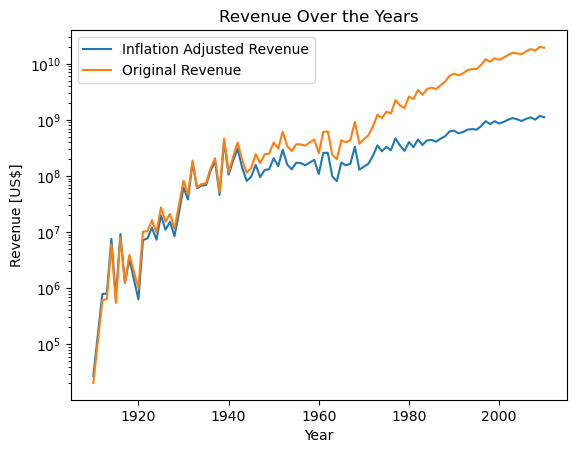

In [98]:
df_inflation = revenue_inflation_correction(movies_features_inc, inflation_raw)

# 'movies2_clean' ot whatever dataset is the right one...

In [99]:
df_inflation[df_inflation['year'] == 1915]

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl
292,Kindling,1915,Kindling,6.6,31.0,14626970,/m/03gr3s9,<NA>,"[Silent film, English Language]",[USA],"[Crime Fiction, Silent film, Drama, Indie, Bla...",66036.0,NaN,False,False,0,0,82545.0
1298,The Captive,1915,The Captive,6.5,128.0,14616918,/m/03gqqyf,50.0,"[Silent film, English Language]",[USA],"[Silent film, Romance Film, Drama, Indie, Blac...",56075.0,NaN,False,False,0,0,70093.75
1851,The Warrens of Virginia,1915,The Warrens of Virginia,5.9,23.0,14616220,/m/03gqq2m,<NA>,"[Silent film, English Language]",[USA],"[Silent film, Drama, Indie, Black-and-white]",85770.0,NaN,False,False,0,0,107212.5
2484,The Arab,1915,The Arab,5.1,49.0,14617357,/m/03gqrgm,50.0,"[Silent film, English Language]",[USA],"[Silent film, Adventure, Black-and-white, Indie]",68527.0,NaN,False,False,0,0,85658.75
5464,Chimmie Fadden Out West,1915,Chimmie Fadden Out West,4.9,23.0,14627259,/m/03gr45c,50.0,"[Silent film, English Language]",[USA],"[Silent film, Western, Indie, Black-and-white,...",72036.0,NaN,False,False,0,0,90045.0
6095,Alice in Wonderland,1915,Alice in Wonderland,6.2,516.0,23669602,/m/06zr25h,52.0,[English Language],[USA],"[Silent film, Black-and-white]",97477.0,NaN,False,False,0,0,121846.25
8989,The Girl of the Golden West,1915,The Girl of the Golden West,5.4,55.0,14614654,/m/03gqn62,50.0,"[Silent film, English Language]",[USA],"[Silent film, Western, Black-and-white, Indie]",102224.0,NaN,False,False,0,0,127780.0


The very high total revenue in the year 1915 catches the eye, but the data for it is valid. In 1915 the movie "The Birth of a Nation" was released, which is a movie that was extremely succesful and had a box office revenue of about [50-100 Mio US$ (Wikipedia)](https://en.wikipedia.org/wiki/The_Birth_of_a_Nation). 

### Normalization for counterbalancing natural growth of movie industry

The steady increase in total revenue over time can be explained partly by the ever increasing number of movies released per year. One should however also consider the steady growth of the movie industry, which allows a movie to make much more revenue today (with an international distribution of the movies) as opposed to earlier in time. This effect should be taken into consideration, which is why we perform a regression analysis and normalize the data accordingly:

In [100]:
df_inflation['revenue_part'] = df_inflation.groupby('year')['revenue'].transform(lambda x: x / x.sum())
display(df_inflation.sample(5))
display(df_inflation.shape)
display(df_inflation.info())


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl,revenue_part
3974,Halloween,2007,Halloween,6.0,119962.0,3623103,/m/09qljs,83.0,[English Language],[USA],"[Cult, Horror, Slasher]",86927973.5,NaN,False,False,0,0,5281164.854192,0.004754
2944,Here on Earth,2000,Here on Earth,5.2,8300.0,11613765,/m/02rllws,97.0,[English Language],[USA],"[Romantic drama, Romance Film, Drama, Teen]",10873148.0,NaN,False,False,0,0,795402.194587,0.000925
9155,Hatari!,1962,Hatari!,7.1,13043.0,1955767,/m/068rr4,158.0,"[Swahili Language, English Language]",[USA],"[Romantic comedy, Adventure, Action/Adventure,...",14000000.0,[False],False,True,0,1,5833333.333333,0.022522
5054,Honky Tonk Freeway,1981,Honky Tonk Freeway,5.2,1059.0,13201636,/m/03bypg3,107.0,[English Language],[USA],"[Parody, Ensemble Film, Comedy]",1997105.0,NaN,False,False,0,0,276990.984743,0.000849
4695,The Trial of Billy Jack,1974,The Trial of Billy Jack,4.5,1391.0,9779498,/m/02pryrn,171.0,[English Language],[USA],"[Action, Martial Arts Film, Drama, Political d...",89000000.0,NaN,False,False,0,0,22762148.337596,0.082711


(9427, 19)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9427 non-null   object 
 1   year            9427 non-null   Int64  
 2   alt_name        9427 non-null   object 
 3   rating          9427 non-null   float64
 4   votes           9427 non-null   float64
 5   id_wiki         9427 non-null   int64  
 6   id_freebase     9427 non-null   object 
 7   runtime         9326 non-null   object 
 8   lang            9427 non-null   object 
 9   countries       9427 non-null   object 
 10  genres          9427 non-null   object 
 11  revenue         9427 non-null   object 
 12  winner          1388 non-null   object 
 13  has_won         9427 non-null   bool   
 14  nominated       9427 non-null   bool   
 15  nbr_won         9427 non-null   int64  
 16  nbr_nomination  9427 non-null   int64  
 17  revenue_infl    9427 non-null   o

None

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.505
Model:                            OLS   Adj. R-squared (uncentered):              0.500
Method:                 Least Squares   F-statistic:                              100.1
Date:                Thu, 21 Dec 2023   Prob (F-statistic):                    1.17e-16
Time:                        19:57:29   Log-Likelihood:                         -2081.4
No. Observations:                  99   AIC:                                      4165.
Df Residuals:                      98   BIC:                                      4167.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl,revenue_part,revenue_norm
6368,Hercules,2005,Hercules,5.6,2020.0,4219204,/m/0bc2mh,240.0,[English Language],[USA],"[Drama, Adventure]",8878839.0,NaN,False,False,0,0,572828.322581,0.0006,563223.004698
6882,The Earthling,1980,The Earthling,6.9,1633.0,642867,/m/02zwhl,97.0,[English Language],"[USA, Australia, New Zealand]","[Action/Adventure, Drama, Adventure, World cin...",1528163.0,NaN,False,False,0,0,233664.067278,0.000584,226772.238606
1172,Mississippi,1935,Mississippi,6.6,521.0,8288693,/m/026z4pc,73.0,[English Language],[USA],"[Romantic comedy, Musical, Comedy, Black-and-w...",11290.0,NaN,False,False,0,0,10357.798165,0.000152,9719.585659
6723,Girl in the Cadillac,1995,Girl in the Cadillac,4.8,239.0,23241430,/m/0661cf2,89.0,[English Language],[USA],"[Crime Fiction, Romance Film, Drama, Adventure]",552655.0,NaN,False,False,0,0,45673.966942,0.000068,44696.829828
6546,Village of the Damned,1995,Village of the Damned,5.6,31662.0,1721255,/m/05r1q4,98.0,[English Language],[USA],"[Thriller, Science Fiction, Horror]",9417567.0,NaN,False,False,0,0,778311.322314,0.001163,761660.329851


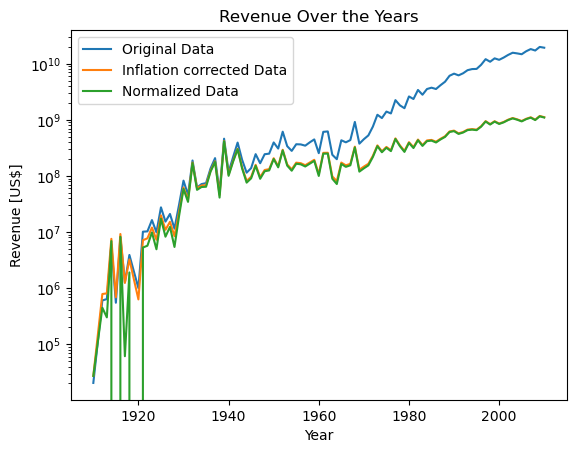

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
2216,The Champ,1979,The Champ,6.8,8575.0,11901160,/m/02rxbsm,117.0,[English Language],[USA],"[Sports, Family Film, Family Drama, Drama, Box...",False,True,0,1,0.018877,5065620.97651
6304,Morituri,1965,Morituri,7.0,3955.0,2967223,/m/08gnr7,128.0,"[English Language, German Language]",[USA],"[Thriller, Period piece, Action, Drama, War film]",False,True,0,2,0.000009,1473.441233
777,Ride 'Em Cowboy,1942,Ride 'Em Cowboy,6.5,1628.0,7148032,/m/0h6sr8,86.0,[English Language],[USA],"[Family Film, Comedy, Black-and-white]",False,False,0,0,0.006711,2010334.660405
4182,Far from Heaven,2002,Far from Heaven,7.4,45000.0,1223711,/m/04jwly,108.0,[English Language],"[France, USA]","[LGBT, Melodrama, Period piece, Marriage Drama...",False,True,0,4,0.002018,2001500.454902
3514,Krull,1983,Krull,6.1,33200.0,4622896,/m/0cd3kf,121.0,[English Language],"[USA, United Kingdom]","[Science Fiction, Sword and sorcery films, Sto...",False,False,0,0,0.006922,2373426.144246


(9427, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9427 non-null   object 
 1   year            9427 non-null   Int64  
 2   alt_name        9427 non-null   object 
 3   rating          9427 non-null   float64
 4   votes           9427 non-null   float64
 5   id_wiki         9427 non-null   int64  
 6   id_freebase     9427 non-null   object 
 7   runtime         9326 non-null   object 
 8   lang            9427 non-null   object 
 9   countries       9427 non-null   object 
 10  genres          9427 non-null   object 
 11  has_won         9427 non-null   bool   
 12  nominated       9427 non-null   bool   
 13  nbr_won         9427 non-null   int64  
 14  nbr_nomination  9427 non-null   int64  
 15  revenue_part    9427 non-null   object 
 16  revenue_norm    9427 non-null   object 
dtypes: Int64(1), bool(2), float64(2),

None

In [101]:
movies_features = df_inflation.copy(deep=True)
movies_features = revenue_normalisation(df_inflation).drop(columns=['winner', 'revenue_infl', 'revenue'])

display(movies_features.sample(5))
display(movies_features.shape)
display(movies_features.info())


### b) Reviews

### c) Awards

### d) Plot similarity

As mentioned before, we're aiming to establish a measure to determine whether a selected movie influences other films within the same genre post-trend. To achieve this, we utilize the plots of movies obtained from Wikipedia. The goal is to develop a tool that allows us to assess similarities between movie plots. Essentially, if the plots of two different movies are highly alike, we can infer that one movie may have inspired the other. By generalizing to multiple movie we could find which movie inspire the one of the trend. To assessthe plot similarity we will NLP method.

 - Before analyse plot similarity we need to **load** the dataset and **merge** it with movies clean dataframe.

In [102]:
MOVIES_PLOT = MOVIES_FOLDER + "plot_summaries.txt"
df_plot = pd.read_csv(MOVIES_PLOT, sep='\t', names=['id_wiki', 'plot'])

merged_df = df_plot.merge(movies, on='id_wiki')
merged_df.columns
display(merged_df)


,id_wiki,plot,id_freebase,name,year,revenue,runtime,lang,countries,genres
0,2231378,"The Lemon Drop Kid , a New York City swindler,...",/m/06xtz3,The Lemon Drop Kid,1951,2300000.0,91.0,[English Language],[USA],"[Screwball comedy, Comedy]"
1,595909,Seventh-day Adventist Church pastor Michael Ch...,/m/02tqm5,A Cry in the Dark,1988,6908797.0,121.0,[English Language],"[USA, Australia, New Zealand]","[Crime Fiction, Drama, Docudrama, World cinema..."
2,5272176,The president is on his way to give a speech. ...,/m/0dbxtv,End Game,2006,NaN,93.0,[English Language],"[USA, Canada, Germany]","[Thriller, Action/Adventure, Action, Drama]"
3,1952976,"{{plot}} The film opens in 1974, as a young gi...",/m/068jvg,Dark Water,2005,49483352.0,105.0,[English Language],[USA],"[Thriller, Drama, Horror]"
4,24225279,"The story begins with Hannah, a young Jewish t...",/m/07kbs3s,Sing,1989,2260616.0,98.0,[English Language],[USA],"[Drama, Teen]"
...,...,...,...,...,...,...,...,...,...,...
18166,11957333,Clarence Mumford is a Robitussin addict living...,/m/02rzlj4,Ninja Bachelor Party,1991,NaN,30.0,[English Language],[USA],"[Parody, Indie, Absurdism, Action Comedy, Shor..."
18167,26261438,While drinking alone one night and reminiscing...,/m/0b76dxj,Outlaw of Gor,1989,NaN,89.0,[English Language],[USA],"[Science Fiction, Fantasy Adventure, Adventure]"
18168,17208834,A high school prom in Georgia is unexpectedly ...,/m/04ydw1v,Dance of the Dead,2008,NaN,87.0,[English Language],[USA],"[Zombie Film, Horror, Indie, Teen, Comedy]"
18169,2867597,"An attempt to bring the famed ""Mr. Bill"" clay ...",/m/087whb,Mr. Bill's Real Life Adventures,1986,NaN,43.0,[English Language],[USA],"[Comedy, Slapstick]"


### *Tokenization, removing the stop words and stemming*



To figure out if plots are similar, we use text analysis, which involves a few steps.

-  First, we break down each plot into separate words. After that, we get rid of the words like 'and,' 'but,' in' (a.k.a stopwords) they're common but don't give much info about the plot. Moreover we also remove punction of the plot that is only use to fluidify the reading.

- Once we remove stopwords, we then simplify each word through a process called stemming. Stemming is the process of simplifying words to their base or root form, facilitating the grouping of different word variations with similar meanings.For example we can convert words like "running" or "runner" to the root "run."

- Finally we make a tokenization  that involves breaking down a text into smaller units, often words or phrases referred to as tokens. In our context, after the initial text processing steps, each remaining word can be considered a token. 

Here is a quick example of with on of the favorites quote of our wrestler : *"In the ring, I am a force to be reckoned with. My strength and determination know no bounds. I'll crush any opponent who dares to step into my territory."*

In [103]:
# Example plot
original_plot = "In the ring, I am a force to be reckoned with. My strength and determination know no bounds. I'll crush any opponent who dares to step into my territory."


# Remove stopwords and punctuation

plot_without_stopwords_and_punctuation = remove_stopwords_and_punctuation(original_plot)

# Apply stemming
speech_after_stemming = apply_stemming(plot_without_stopwords_and_punctuation)


print("Original Plot:")
print(original_plot)

print("\nPlot After Removing Stopwords and Punctuation:")
print(" ".join(plot_without_stopwords_and_punctuation))

print("\nSpeech After Removing Stopwords, Punctuation, and Stemming:")
print(" ".join(speech_after_stemming))

Original Plot:
In the ring, I am a force to be reckoned with. My strength and determination know no bounds. I'll crush any opponent who dares to step into my territory.

Plot After Removing Stopwords and Punctuation:
ring force reckoned strength determination know bounds 'll crush opponent dares step territory

Speech After Removing Stopwords, Punctuation, and Stemming:
ring forc reckon strength determin know bound ll crush oppon dare step territori


Hence the quote bofore NLP :

  *"In the ring, I am a force to be reckoned with. My strength and determination know no bounds. I'll crush any opponent who dares to step into my territory."* 

Become :


 *"ring force reckoned strength determination know bounds 'll crush opponent dares step territory"*

 Note that we still understand the sense of this quote even if it look like our catcher spoke like Yoda matser

### TF-IDF matrix and Similarity matrix


Now, we are left with the basic form of words, and we can initiate the comparison of plots. To facilitate this, we generate something known as a TF-IDF matrix. This matrix assesses the frequency of each word in the plots and assigns significance to words that are infrequently present. The objective is to highlight words that do not frequently appear across all the plots. This process enables us to establish connections between films by evaluating the similarity in the importance of words within each plot.

To evaluate this similarity, we employ the cosine similarity between two plots. This procedure is repeated for all films, culminating in the construction of a similarity matrix. The goal is to comprehend the proximity of films by examining how closely the importance of each word aligns with others.

Here is what looks like a sample of this similarity matrix : we see that this matrix is symetric and the diagonal is fullfill of one. Indeed a cell of the matrix for example the cell (8,9) is the cosine disrance between plot of index 8 and plot of index 9 of the merged dataframe. The score is between 0 and 1. A score of 0 indicates that plot are completly different whereas one means that plots are the same. That is why the diagonal is composed only by one element. Because we compare the plot of a film to itself.

In [104]:
similarity_matrix = similarity_calculation(merged_df, 'plot')

c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 't

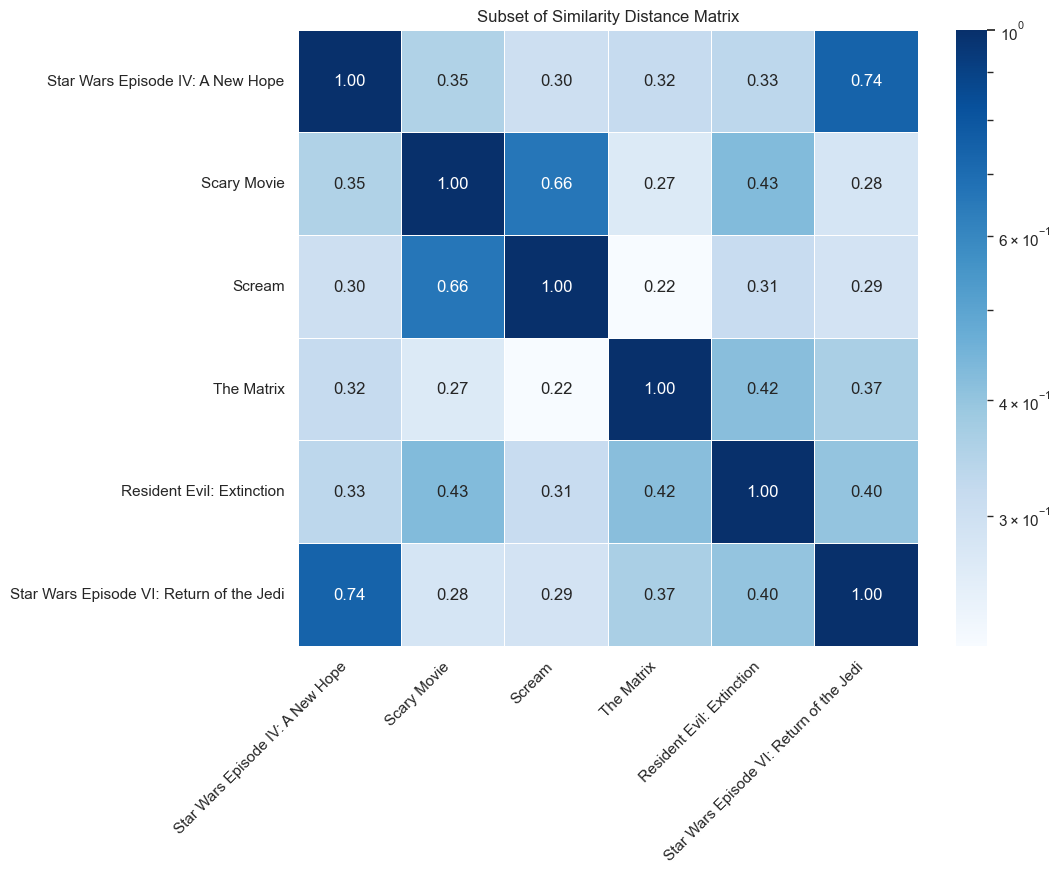

In [105]:
from helpers import * 

# Additional import for colormap
import matplotlib.cm as cm

film_names = [
    'Star Wars Episode IV: A New Hope',
    'Star Wars Episode VI: Return of the Jedi',
    'Resident Evil: Extinction',
    'The Matrix',
    'Scary Movie',
    'Scream'
]


# Assuming similarity_matrix and indices_list are defined elsewhere in your code
similarity_plot(similarity_matrix,merged_df, film_names)


In [106]:
NAME_OF_THE_MOVIE= 'Star Wars'
display( merged_df[merged_df['name'].str.contains(NAME_OF_THE_MOVIE, case=False, na=False)])

,id_wiki,plot,id_freebase,name,year,revenue,runtime,lang,countries,genres
1642,53964,The film begins with an opening crawl explain...,/m/0f3m1,Star Wars Episode V: The Empire Strikes Back,1980,5.383751e+08,124.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
3429,50957,The Galactic Republic is in turmoil. Followin...,/m/0dfw0,Star Wars Episode II: Attack of the Clones,2002,6.493983e+08,142.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
3647,52549,The film begins with an opening crawl explain...,/m/0dtfn,Star Wars Episode IV: A New Hope,1977,7.753980e+08,122.0,[English Language],[USA],"[Science Fiction, Adventure, Fantasy, Coming o..."
8019,185264,"It is Life Day . Chewbacca, accompanied by Han...",/m/0199wf,The Star Wars Holiday Special,1978,NaN,97.0,[English Language],[USA],"[Science Fiction, Adventure, Holiday Film, Ani..."
10264,50793,The Galactic Republic is in a period of decli...,/m/0ddt_,Star Wars Episode I: The Phantom Menace,1999,1.027045e+09,136.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Adventure, ..."
10456,3336298,The special was hosted by C-3PO and R2-D2.{{c...,/m/096gqt,The Making of Star Wars,1977,NaN,50.0,[English Language],[USA],[Documentary]
11747,55447,"As the Clone Wars rage on, the Galactic Repub...",/m/0fdv3,Star Wars Episode III: Revenge of the Sith,2005,8.487548e+08,140.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Tragedy, Ad..."
13621,50744,Luke Skywalker initiates a plan to rescue Han...,/m/0ddjy,Star Wars Episode VI: Return of the Jedi,1983,4.751062e+08,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
14559,15726696,The Separatists control the majority of the hy...,/m/0cpllql,Star Wars: The Clone Wars,2008,6.828284e+07,90.0,[English Language],[USA],"[Thriller, Science Fiction, Adventure, Compute..."
15695,1861566,"Though a Star Wars fan as a child, life holds ...",/m/061wqh,Saving Star Wars,2004,NaN,117.0,[English Language],[USA],"[Indie, Comedy]"


With this matrix, we can explore interesting features, such as identifying the top 10 most similar films for a given movie. Let's apply this to "Star Wars IV."

In [107]:

import numpy as np
import pandas as pd


given_movie_index = 3647  # Replace with the index of the movie you're interested in
max_indices = np.argpartition(similarity_matrix[given_movie_index], -10)[-10:]
given_movie_name = merged_df.iloc[given_movie_index]['name']

print("Given Movie Name:", given_movie_name)
print("Top 10 Most Similar Movie Names:")

for i, index in enumerate(max_indices):
    if index !=given_movie_index:
        movie_name = merged_df.iloc[index]['name']
        print(f"Top {9-i} 🎬: {movie_name}")

Given Movie Name: Star Wars Episode IV: A New Hope
Top 10 Most Similar Movie Names:
Top 9 🎬: Star Wars Episode V: The Empire Strikes Back
Top 8 🎬: Postal
Top 7 🎬: Attack on the Iron Coast
Top 6 🎬: Harry Potter and the Deathly Hallows: Part I
Top 5 🎬: Under Siege 2: Dark Territory
Top 4 🎬: Mom and Dad Save The World
Top 3 🎬: Harry Potter and the Half-Blood Prince
Top 2 🎬: Blood Alley
Top 1 🎬: Star Wars Episode VI: Return of the Jedi


But the most important features to assess the impact of a movie will be to compute the mean similarity before and after:

- Mean similarity before is the average similarity between a given movie and the movie released 7 years before of the same genre
- Mean similarity after is the average similarity between a given movie and the movie released 7 years after of the same genre

If a movie had a big impact on the industry such that everyone want to copy it the difference between mean similarity before and mean similarity after will be bigger than other film. Of course it only take into account plot and not other aspects of a movie such as special effects, narration, sound effect, etc.. . However it can still confirm if a movie was a source of inspiration for others movie during the trend

Here is the example of Star Wars IV we see that there is a noticeble difference compare to a random film

In [108]:
# Example usage:


film_name = 'Star Wars Episode IV: A New Hope'
movie_index = merged_df[merged_df['name']==film_name].index[0] 
genre='Science Fiction'


mean_similarity_before, mean_similarity_after = calculate_mean_similarity_2(movie_index, merged_df, similarity_matrix, genre)


print(f"The film of '{genre}' released 7 years before '{film_name}' share an average similarity in the plot of  : {mean_similarity_before:.2f}")
print(f"The film of '{genre}' released 7 years after '{film_name}' share an average similarity in the plot of  : {mean_similarity_after:.2f}")


The film of 'Science Fiction' released 7 years before 'Star Wars Episode IV: A New Hope' share an average similarity in the plot of  : 0.22
The film of 'Science Fiction' released 7 years after 'Star Wars Episode IV: A New Hope' share an average similarity in the plot of  : 0.28


### 3.1) TEST

### 3.2) Serious Buisness Machine learning

In [109]:
from helpers import *


In [110]:
# CREATION OF DF_CANDIDATES



min_elements = 3  # You can set the minimum number of elements for the if loop
result_df = process_candidates(candidates, min_elements,movies_features,merged_df,similarity_matrix)
display(result_df)

c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

,id_wiki,name,year,alt_name,rating,votes,genres,nbr_won,nbr_nomination,revenue_norm,trend_number,trend_genre,year_from_trend,mean_similarity_before,mean_similarity_after
0,3059075,Brain Donors,1992,Brain Donors,7.1,4100.0,"[Absurdism, Buddy film, Comedy, Slapstick]",0,0,80626.129373,1,Absurdism,-2,0.134835,0.095742
1,1716921,Amazon Women on the Moon,1987,Amazon Women on the Moon,6.2,11932.0,"[Parody, Cult, Science Fiction, Comedy, Absurd...",0,0,59116.397417,1,Absurdism,3,0.160908,0.187811
2,75222,Spaceballs,1987,Spaceballs,7.1,188893.0,"[Parody, Science Fiction, Adventure, Absurdism...",0,0,4106985.482572,1,Absurdism,3,0.244459,0.303527
3,77744,Wayne's World,1992,Wayne's World,7.0,156437.0,"[Buddy film, Absurdism, Cult, Satire, Comedy, ...",0,0,15259090.368721,1,Absurdism,-2,0.243568,0.287433
4,1048388,Hot Shots!,1991,Hot Shots!,6.7,107858.0,"[Parody, Absurdism, Action/Adventure, Comedy, ...",0,0,15822970.580486,1,Absurdism,-1,0.186635,0.245078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4554,1033297,Resident Evil,2002,Resident Evil,6.6,269222.0,"[Thriller, Science Fiction, Horror, Adventure,...",0,0,6865491.244426,386,Zombie Film,0,NaN,NaN
4555,3238135,House of the Dead,2003,House of the Dead,2.1,37372.0,"[Thriller, Horror, World cinema, Action/Advent...",0,0,1015218.809581,386,Zombie Film,-1,0.265207,0.315652
4556,538455,Dawn of the Dead,2004,Dawn of the Dead,7.3,253892.0,"[Thriller, Science Fiction, Horror, Doomsday f...",0,0,6942198.512008,386,Zombie Film,-2,0.291442,0.337030
4557,145892,28 Days Later,2002,28 Days Later...,7.5,406833.0,"[Thriller, Science Fiction, Horror, Doomsday f...",0,0,4951485.502061,386,Zombie Film,0,0.271120,0.332539


In [111]:
# FILTERING 

# Now we have the big candidates DataFrame we will Filter the non-interesting trends i.e. trends with less than 10 candidates
filtered_result_df = filter_candidates(result_df)
display(filtered_result_df)




There are 2333 different movies


,id_wiki,name,year,alt_name,rating,votes,genres,nbr_won,nbr_nomination,revenue_norm,trend_number,trend_genre,year_from_trend,mean_similarity_before,mean_similarity_after
0,3059075,Brain Donors,1992,Brain Donors,7.1,4100.0,"[Absurdism, Buddy film, Comedy, Slapstick]",0,0,80626.129373,1,Absurdism,-2,0.134835,0.095742
1,1716921,Amazon Women on the Moon,1987,Amazon Women on the Moon,6.2,11932.0,"[Parody, Cult, Science Fiction, Comedy, Absurd...",0,0,59116.397417,1,Absurdism,3,0.160908,0.187811
2,75222,Spaceballs,1987,Spaceballs,7.1,188893.0,"[Parody, Science Fiction, Adventure, Absurdism...",0,0,4106985.482572,1,Absurdism,3,0.244459,0.303527
3,77744,Wayne's World,1992,Wayne's World,7.0,156437.0,"[Buddy film, Absurdism, Cult, Satire, Comedy, ...",0,0,15259090.368721,1,Absurdism,-2,0.243568,0.287433
4,1048388,Hot Shots!,1991,Hot Shots!,6.7,107858.0,"[Parody, Absurdism, Action/Adventure, Comedy, ...",0,0,15822970.580486,1,Absurdism,-1,0.186635,0.245078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4553,1802400,Phantasm,1979,Phantasm,6.6,36816.0,"[Cult, Zombie Film, Horror, Slasher, Supernatu...",0,0,1994926.835079,385,Zombie Film,1,0.160399,0.131133
4555,3238135,House of the Dead,2003,House of the Dead,2.1,37372.0,"[Thriller, Horror, World cinema, Action/Advent...",0,0,1015218.809581,386,Zombie Film,-1,0.265207,0.315652
4556,538455,Dawn of the Dead,2004,Dawn of the Dead,7.3,253892.0,"[Thriller, Science Fiction, Horror, Doomsday f...",0,0,6942198.512008,386,Zombie Film,-2,0.291442,0.337030
4557,145892,28 Days Later,2002,28 Days Later...,7.5,406833.0,"[Thriller, Science Fiction, Horror, Doomsday f...",0,0,4951485.502061,386,Zombie Film,0,0.271120,0.332539


In [112]:
# STANDARDIZATION

# Standardization of the features: we standardize the feature for EACH TRENDS
re = filtered_result_df.copy()
features_to_standardize = ['rating', 'nbr_won','votes', 'nbr_nomination', 'revenue_norm', 'mean_similarity_before','mean_similarity_after']
result_df_standardized = standardize_features(re, features_to_standardize)
display(result_df_standardized)

There are 2333 different movies


,trend_number,level_1,id_wiki,name,year,alt_name,rating,votes,genres,nbr_won,nbr_nomination,revenue_norm,trend_genre,year_from_trend,mean_similarity_before,mean_similarity_after
0,1,0,3059075,Brain Donors,1992,Brain Donors,0.847998,-1.088884,"[Absurdism, Buddy film, Comedy, Slapstick]",0.0,0.0,-0.857201,Absurdism,-2,-1.492129,-1.884345
1,1,1,1716921,Amazon Women on the Moon,1987,Amazon Women on the Moon,-2.013996,-0.980737,"[Parody, Cult, Science Fiction, Comedy, Absurd...",0.0,0.0,-0.860321,Absurdism,3,-0.938718,-0.657046
2,1,2,75222,Spaceballs,1987,Spaceballs,0.847998,1.462800,"[Parody, Science Fiction, Adventure, Absurdism...",0.0,0.0,-0.273164,Absurdism,3,0.834702,0.885471
3,1,3,77744,Wayne's World,1992,Wayne's World,0.529999,1.014637,"[Buddy film, Absurdism, Cult, Satire, Comedy, ...",0.0,0.0,1.344486,Absurdism,-2,0.815793,0.670945
4,1,4,1048388,Hot Shots!,1991,Hot Shots!,-0.423999,0.343841,"[Parody, Absurdism, Action/Adventure, Comedy, ...",0.0,0.0,1.426279,Absurdism,-1,-0.392652,0.106339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3849,385,4553,1802400,Phantasm,1979,Phantasm,0.000000,0.018298,"[Cult, Zombie Film, Horror, Slasher, Supernatu...",0.0,0.0,-0.058512,Zombie Film,1,-0.730356,-1.023461
3850,386,4555,3238135,House of the Dead,2003,House of the Dead,-1.650452,-0.863374,"[Thriller, Horror, World cinema, Action/Advent...",0.0,0.0,-0.816298,Zombie Film,-1,-1.237990,-0.001698
3851,386,4556,538455,Dawn of the Dead,2004,Dawn of the Dead,0.750205,0.470276,"[Thriller, Science Fiction, Horror, Doomsday f...",0.0,0.0,1.320653,Zombie Film,-2,1.022588,0.911062
3852,386,4557,145892,28 Days Later,2002,28 Days Later...,0.842538,1.412313,"[Thriller, Science Fiction, Horror, Doomsday f...",0.0,0.0,0.602909,Zombie Film,0,-0.728509,0.719305


In [113]:
# PIVOTAL MOVIES
STAR_WARS_IV = result_df_standardized[(result_df_standardized['id_wiki'] == 52549) & (result_df_standardized['trend_number'] == 320)].head(1)
THE_KARATE_KID = result_df_standardized[(result_df_standardized['id_wiki'] == 91133) & (result_df_standardized['trend_number'] == 247)].head(1)
TRANSFORMERS_MOVIE = result_df_standardized[(result_df_standardized['id_wiki'] == 76515) & (result_df_standardized['trend_number'] == 236)].head(1)
TOY_STORY = result_df_standardized[(result_df_standardized['id_wiki'] == 53085) & (result_df_standardized['trend_number'] == 102)].head(1)
JERRY_MAGUIRE = result_df_standardized[result_df_standardized['id_wiki'] == 142435].head(1)
WEREWOLF_IN_LONDON = result_df_standardized[result_df_standardized['id_wiki'] == 471370].head(1)
THE_LION_KING = result_df_standardized[(result_df_standardized['id_wiki'] == 88678) & (result_df_standardized['trend_number'] == 31)].head(1)
ROSEMARYS_BABY = result_df_standardized[(result_df_standardized['id_wiki'] == 9830229) & (result_df_standardized['trend_number'] == 225)].head(1)
ROCKY_HORROR_PICTURE_SHOW = result_df_standardized[(result_df_standardized['id_wiki'] == 25491) & (result_df_standardized['trend_number'] == 226)].head(1)
BEVERLY_HILLS_COP = result_df_standardized[(result_df_standardized['id_wiki'] == 680398) & (result_df_standardized['trend_number'] == 66)].head(1)

PIVOTAL=pd.concat([STAR_WARS_IV,THE_KARATE_KID,TRANSFORMERS_MOVIE,TOY_STORY,JERRY_MAGUIRE,WEREWOLF_IN_LONDON,THE_LION_KING,ROSEMARYS_BABY,ROCKY_HORROR_PICTURE_SHOW,BEVERLY_HILLS_COP])

# NON-PIVOTAL MOVIES
SCI_FI=  result_df_standardized[(result_df_standardized['id_wiki'] != 52549) & (result_df_standardized['trend_number'] == 320)]
CLOSE_ENCOUNTERS = result_df_standardized[(result_df_standardized['id_wiki'] == 146236) & (result_df_standardized['trend_number'] == 320)].head(1)
LORD_JIM = result_df_standardized[(result_df_standardized['id_wiki'] == 4693134) & (result_df_standardized['trend_number'] == 2)].head(1)
KARATE_KID_NON_PIVOTAL = result_df_standardized[(result_df_standardized['id_wiki'] == 91133) & (result_df_standardized['trend_number'] == 236)].head(1)
STAR_WARS_IV_NON_PIVOTAL = result_df_standardized[(result_df_standardized['id_wiki'] == 52549) & (result_df_standardized['trend_number'] == 100)].head(1)
THE_LION_KING_NON_PIVOTAL = result_df_standardized[(result_df_standardized['id_wiki'] == 88678) & (result_df_standardized['trend_number'] == 101)].head(1)
BEVERLY_HILLS_COP_NON_PIVOTAL = result_df_standardized[(result_df_standardized['id_wiki'] == 680398) & (result_df_standardized['trend_number'] == 368)].head(1)
THE_OCTAGON = result_df_standardized[(result_df_standardized['id_wiki'] == 9782726) & (result_df_standardized['trend_number'] == 247)].head(1)
RETURN_OF_THE_KING = result_df_standardized[(result_df_standardized['id_wiki'] == 516463) & (result_df_standardized['trend_number'] == 236)].head(1)
THE_BIRDS = result_df_standardized[(result_df_standardized['id_wiki'] == 304428) & (result_df_standardized['trend_number'] == 225)].head(1)
NON_PIVOTAL=pd.concat( [SCI_FI,CLOSE_ENCOUNTERS,LORD_JIM,KARATE_KID_NON_PIVOTAL,STAR_WARS_IV_NON_PIVOTAL,THE_LION_KING_NON_PIVOTAL,BEVERLY_HILLS_COP_NON_PIVOTAL,THE_OCTAGON,RETURN_OF_THE_KING,THE_BIRDS])
# Concatenate all DataFrames
all_movies=pd.concat([PIVOTAL,NON_PIVOTAL])

# Extract relevant features for

# Extract relevant features for training
features_train = all_movies[['rating', 'nbr_won','votes', 'nbr_nomination', 'revenue_norm', 'mean_similarity_before','mean_similarity_after','year_from_trend']]

# Create the target variable y_train (1 for pivotal movies, 0 for non-pivotal movies)
y_train = [1] * 10 + [0] * 9 + [0] *len(SCI_FI)

# Display the concatenated DataFrame
display(features_train)

# Display y_train
print(y_train)


,rating,nbr_won,votes,nbr_nomination,revenue_norm,mean_similarity_before,mean_similarity_after,year_from_trend
2845,1.953702,7.420364,6.019363,5.030470,7.069937,0.603609,0.836624,0
2267,1.612032,0.000000,3.674089,3.162278,4.172645,-0.497406,0.275880,2
2205,0.861000,0.000000,0.186968,-0.301511,-0.513635,0.854920,1.303723,0
980,1.420577,-0.408248,2.127009,1.720618,1.069442,-0.882125,0.566491,5
3002,1.139715,8.124038,3.854537,6.759109,4.317177,0.870513,0.800278,1
...,...,...,...,...,...,...,...,...
929,2.061966,2.286419,3.177675,1.710234,6.407750,0.177397,0.494982,1
3613,1.350868,-0.147602,1.322594,0.770349,7.125747,1.384703,1.473284,3
2253,-0.874822,0.000000,-0.458809,-0.316228,0.515432,0.458057,1.221334,6
2209,-0.916549,0.000000,-0.414293,-0.301511,-0.710226,-0.207326,-0.302334,6


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [114]:
# INFO FROM TRAINING

from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(features_train,y_train)
# Print coefficients
print("Coefficients:", logistic.coef_)

# Print intercept
print("Intercept:", logistic.intercept_)

Coefficients: [[0.92007701 0.37578254 0.2721308  0.07969161 0.0147482  0.01198953
  1.15156201 0.16397224]]
Intercept: [-4.35984605]


In [115]:
# PREDICTION FOR EVERY TRENDS

from sklearn.linear_model import LogisticRegression

# Assuming features_train and y_train are defined
# ...

grouped_by_trend = result_df_standardized.groupby('trend_number')
# Dictionary to store most likely pivotal movie for each group
most_likely_pivotal = {}

# Iterate over groups
for trend_number, group_df in grouped_by_trend:
    # Select features and labels for the group
    features_group = group_df[['rating', 'nbr_won','votes', 'nbr_nomination', 'revenue_norm', 'mean_similarity_before','mean_similarity_after','year_from_trend']]
    
    # Predict probabilities for being pivotal
    probabilities = logistic.predict_proba(features_group)[:, 1]
    
    # Identify the index with the highest probability
    most_likely_index = probabilities.argmax()
    
    # Get the details of the most likely pivotal movie
    most_likely_movie = group_df.iloc[most_likely_index]
    
    # Store the result in the dictionary
    most_likely_pivotal[trend_number] = most_likely_movie

# Display the most likely pivotal movie for each group
for trend_number, movie_info in most_likely_pivotal.items():
    print(f"Trend {candidates[int(trend_number)][0]} of year {candidates[int(trend_number)][2]}: Most Likely Pivotal Movie - {movie_info['name']}")



Trend Absurdism of year 1990: Most Likely Pivotal Movie - Spaceballs
Trend Action of year 1967: Most Likely Pivotal Movie - Lawrence of Arabia
Trend Action Thrillers of year 1967: Most Likely Pivotal Movie - Bullitt
Trend Action Thrillers of year 1987: Most Likely Pivotal Movie - First Blood
Trend Action/Adventure of year 1966: Most Likely Pivotal Movie - Lawrence of Arabia
Trend Addiction Drama of year 1986: Most Likely Pivotal Movie - Clean and Sober
Trend Adventure Comedy of year 1979: Most Likely Pivotal Movie - The Blues Brothers
Trend Airplanes and airports of year 1973: Most Likely Pivotal Movie - 2001 A Space Odyssey
Trend Albino bias of year 1992: Most Likely Pivotal Movie - Lethal Weapon
Trend Animal Picture of year 1992: Most Likely Pivotal Movie - Homeward Bound The Incredible Journey
Trend Animated Musical of year 1969: Most Likely Pivotal Movie - Here Comes Peter Cottontail
Trend Animated Musical of year 1994: Most Likely Pivotal Movie - The Lion King
Trend Animation of y

In [116]:
!pip install networkx

In [117]:
NAME_OF_THE_MOVIE= 'Night of the'
display( merged_df[merged_df['name'].str.contains(NAME_OF_THE_MOVIE, case=False, na=False)])


,id_wiki,plot,id_freebase,name,year,revenue,runtime,lang,countries,genres
648,21488993,"The movie opens in 1925, with scenes of gore a...",/m/05h573m,Night of the Demons,2010,NaN,93.0,[English Language],[USA],"[Horror, Teen]"
1506,4538926,Six years have passed since the horrifying mas...,/m/02vkfr7,Night of the Demons 2,1994,NaN,96.0,[English Language],[USA],"[Horror, Comedy, Teen]"
1972,3216798,"In this latest interpretation, the characters ...",/m/08z_2d,Night of the Living Dead 3D,2006,1553837.0,80.0,[English Language],[USA],"[Zombie Film, Horror, Indie, Creature Film]"
2260,673306,The plot revolves around a confidence trickste...,/m/031s9x,Night of the Ghouls,1987,NaN,69.0,[English Language],[USA],"[Detective fiction, B-movie, Detective, Psycho..."
2820,10664680,"On Halloween night, Officer Larry is on night...",/m/02qlnmb,Night of the Demons 3,1997,NaN,88.0,[English Language],"[USA, Canada]","[Horror, Haunted House Film, Teen]"
3511,10685113,A warlock comes back to life in the form of a ...,/m/02qm6cr,Night of the Scarecrow,1995,NaN,85.0,[English Language],[USA],"[Science Fiction, Horror]"
4021,21740728,Everyone knows someone who's had a run-in with...,/m/05mslhz,Coons! Night of the Bandits of the Night,2005,NaN,80.0,[English Language],[USA],"[B-movie, Indie, Musical comedy, Musical, Come..."
4949,2831521,"Presented in flashback, the film tells the sto...",/m/085j2d,Night Of The Demon,1980,NaN,92.0,[English Language],[USA],[Horror]
5048,4482293,Two people are attacked in a cemetery when sli...,/m/0c4xfr,Night of the Living Bread,1990,NaN,8.0,[English Language],[USA],"[Parody, Short Film]"
6781,1958642,The murder of a prostitute in Nazi-occupied Wa...,/m/068__1,The Night of the Generals,1967,NaN,137.0,"[French Language, Italian Language, English La...","[France, USA, United Kingdom]","[Thriller, Psychological thriller, Mystery, Dr..."


In [118]:
import pandas as pd

# Replace 'your_target_id_wiki' with the specific id_wiki you're looking for
target_id_wiki = 30275	
pivotal=merged_df[merged_df['id_wiki']==target_id_wiki]['name'].values[0]
print(pivotal)
# Assuming 'merged_df' is your DataFrame
# Use loc to filter rows based on the 'id_wiki' column and select the 'date_released' column
release_date = merged_df.loc[merged_df['id_wiki'] == target_id_wiki, 'year'].values[0]

# Display or use the release date
print(f"The release date for id_wiki {target_id_wiki} is: {release_date}")


Night of the Living Dead
The release date for id_wiki 30275 is: 1968


In [124]:

science_fiction_movies = movies_features[movies_features['genres'].apply(lambda x: 'Horror' in x)]
release_date = merged_df.loc[merged_df['id_wiki'] == target_id_wiki, 'year'].values[0]
Sci_fi_after_SW= science_fiction_movies[(science_fiction_movies['year']>=release_date -2) & (science_fiction_movies['year']< release_date +7)]
Best_after_SW=Sci_fi_after_SW.sort_values(by='revenue_norm', ascending=False)

first_10_id_wiki = Best_after_SW['id_wiki'].head(8)
id_wiki_list = first_10_id_wiki.tolist()
if target_id_wiki not in id_wiki_list:
    id_wiki_list.append(target_id_wiki)
#id_wiki_list.append(target_id_wiki)
# Display or use the resulting NumPy array
print(id_wiki_list[0])
# Display or use the resulting Series
print(first_10_id_wiki)
Best_after_SW.head(7)


725459
2763      725459
5360     9830229
4606       30275
5625       29781
7198    19755481
514      4586623
6603    11401015
8741     1693762
Name: id_wiki, dtype: int64


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
2763,The Exorcist,1973,The Exorcist,8.1,397362.0,725459,/m/035yn8,120.0,"[Arabic Language, Assyrian Neo-Aramaic Languag...",[USA],"[Demonic child, Horror, Supernatural, Psycholo...",True,True,2,10,0.363481,123508830.923707
5360,Rosemary's Baby,1968,Rosemary's Baby,8.0,212085.0,9830229,/m/02ptczs,136.0,[English Language],[USA],"[Horror, Drama, Psychological thriller, Mystery]",True,True,1,2,0.043749,14129930.824971
4606,Night of the Living Dead,1968,Night of the Living Dead,7.8,127131.0,30275,/m/07g38,96.0,[English Language],[USA],"[Horror, Indie, Doomsday film, Black-and-white...",False,False,0,0,0.033936,10960496.669262
5625,The Texas Chain Saw Massacre,1974,The Texas Chain Saw Massacre,7.4,158429.0,29781,/m/07bw7,75.0,[English Language],[USA],"[Thriller, Mystery, Horror, Cult]",False,False,0,0,0.028678,7583150.658842
7198,Wait Until Dark,1967,Wait Until Dark,7.7,30565.0,19755481,/m/04n3c8_,107.0,[English Language],[USA],"[Thriller, Horror, Psychological thriller, New...",False,False,0,0,0.042301,6545421.093533
514,Queen of Blood,1966,Queen of Blood,5.2,1938.0,4586623,/m/0cb8p6,81.0,[English Language],[USA],"[Science Fiction, Horror]",False,False,0,0,0.044607,6478127.17862
6603,Private Parts,1972,Private Parts,6.5,1630.0,11401015,/m/02rb8gm,86.0,[English Language],[USA],"[Black comedy, Horror, Comedy]",False,False,0,0,0.022861,4980970.079383


In [122]:
tab10_palette = plt.cm.get_cmap("tab10").colors

C:\Users\paulr\AppData\Local\Temp\ipykernel_2788\1098299809.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10_palette = plt.cm.get_cmap("tab10").colors


C:\Users\paulr\AppData\Local\Temp\ipykernel_2788\2963641376.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')  # Using 'Blues' colormap for shades of blue  # Using 'viridis' for lower values
C:\Users\paulr\AppData\Local\Temp\ipykernel_2788\2963641376.py:116: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))


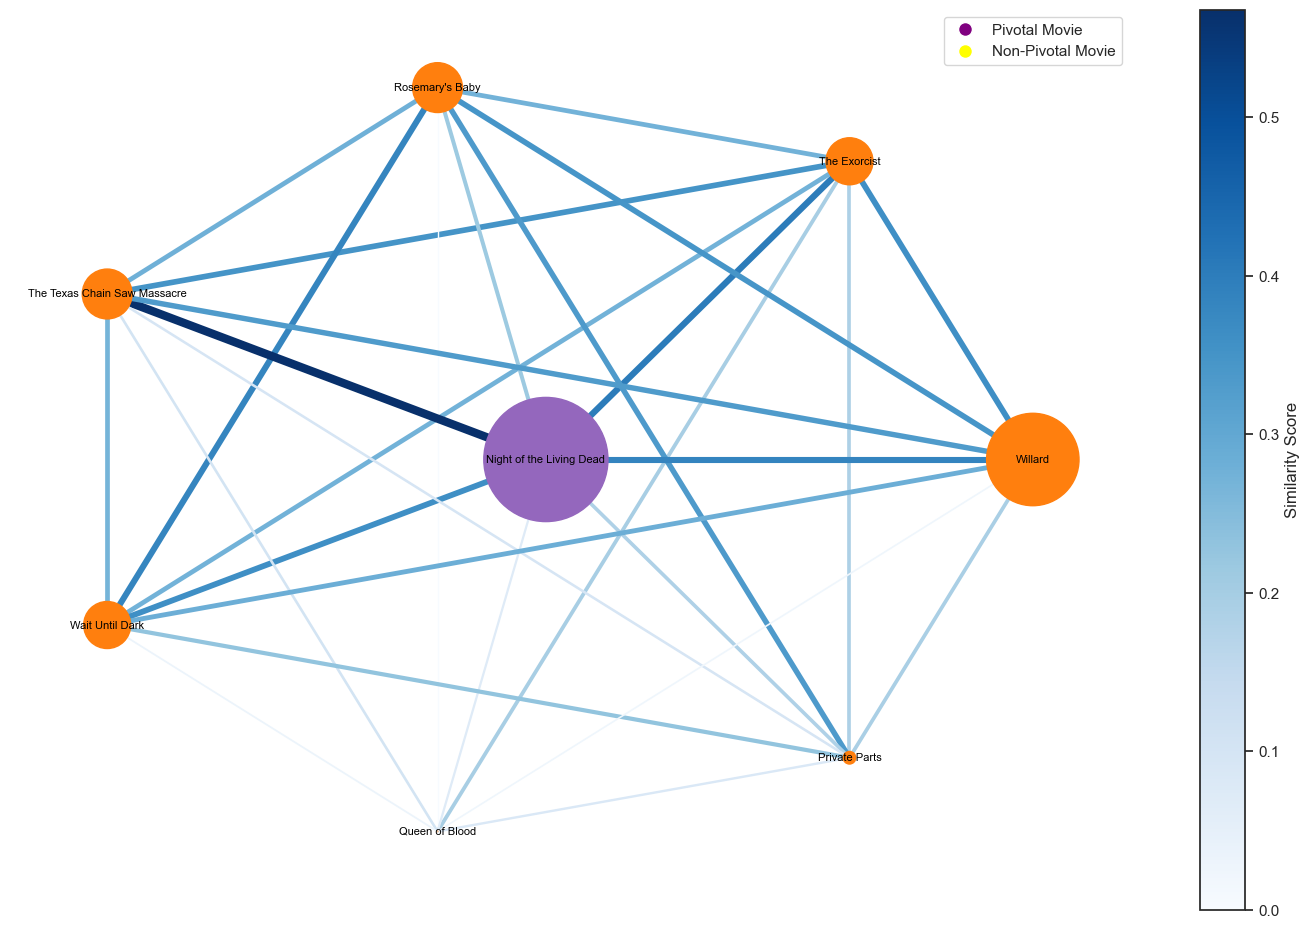

In [125]:
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def compute_plot_similarity(movie1_id, movie2_id):
    return similarity_matrix[movie1_id, movie2_id]

# Assuming id_wiki_list is a list of id_wiki values
# Add more id_wiki values as needed

# Specify the id_wiki for the node you want to label as 'pivotal'

# Create a graph
G = nx.Graph()

# Dictionary to store cumulative similarity scores for each node
cumulative_similarity_scores = {}

# Iterate over pairs of id_wiki values
for i in range(len(id_wiki_list)):
    for j in range(i + 1, len(id_wiki_list)):
        movie1_id = merged_df[merged_df['id_wiki'] == id_wiki_list[i]].index[0]
        movie2_id = merged_df[merged_df['id_wiki'] == id_wiki_list[j]].index[0]

        movie1_name = merged_df.loc[movie1_id, 'name']
        movie2_name = merged_df.loc[movie2_id, 'name']

        # Assuming compute_plot_similarity returns a single similarity score
        similarity_score = compute_plot_similarity(movie1_id, movie2_id)

        # Update cumulative similarity scores for each node
        cumulative_similarity_scores[movie1_id] = cumulative_similarity_scores.get(movie1_id, []) + [similarity_score]
        cumulative_similarity_scores[movie2_id] = cumulative_similarity_scores.get(movie2_id, []) + [similarity_score]

        # Add nodes
        G.add_node(movie1_id, label=movie1_name, size=sum(cumulative_similarity_scores[movie1_id]))
        G.add_node(movie2_id, label=movie2_name, size=sum(cumulative_similarity_scores[movie2_id]))

        # Add edge with weight
        G.add_edge(movie1_id, movie2_id, weight=similarity_score)

# Compute median similarity scores for each node
median_similarity_scores = {node: np.median(scores) for node, scores in cumulative_similarity_scores.items()}

# Find the central node with the max median similarity score
central_node = max(median_similarity_scores, key=median_similarity_scores.get)

# Set a custom color for the pivotal node

# Determine the number of nodes excluding the central node
num_other_nodes = len(G.nodes) - 1

# Set the radius of the circle
radius = 2.0  # You can adjust this value based on your preference

# Calculate the angle between each node on the circle
angle_increment = 2 * math.pi / num_other_nodes

# Calculate positions for each node on the circle
pos = {central_node: [0, 0]}  # Set the position of the central node
j = 0
for i, node in enumerate(G.nodes):
    if node != central_node:
        j += 1
        angle = j * angle_increment
        x = radius * math.cos(angle) + pos[central_node][0]
        y = radius * math.sin(angle) + pos[central_node][1]
        pos[node] = [x, y]

# Extract edge weights
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Normalize edge weights to use for scaling edge thickness
max_weight = max(edge_weights)
min_weight = min(edge_weights)
scaled_weights = [5 * (weight - min_weight) / (max_weight - min_weight) + 1 for weight in edge_weights]

# Extract node sizes, scaling them with a square root function
# Extract node sizes, scaling them with a square root function
sqrt_scaling_factor = 7  # Adjust this factor for square root scaling
factor= 10
node_sizes = [(median_similarity_scores[n]*10) ** sqrt_scaling_factor for n in G.nodes]


# Extract node colors
node_colors = [tab10_palette[4] if G.nodes[n]['label'] == pivotal else tab10_palette[1] for n in G.nodes]
node_labels = {n: G.nodes[n]['label'] for n in G.nodes}
# Set up a colormap based on similarity scores
cmap = plt.cm.get_cmap('Blues')  # Using 'Blues' colormap for shades of blue  # Using 'viridis' for lower values
norm = Normalize(vmin=min_weight, vmax=max_weight)

# Set a larger plot size
plt.figure(figsize=(14, 9))

# Draw the network with colored edges and edge thickness proportional to similarity score
# Assuming node_labels is a dictionary with node labels
nx.draw(
    G,
    pos,
    with_labels=True,
    labels=node_labels,
    node_size=node_sizes,
    node_color=node_colors,
    width=scaled_weights,
    edge_color=edge_weights,
    edge_cmap=cmap,
    edge_vmin=min_weight,
    edge_vmax=max_weight,
    font_size=8,
    font_color='black'
)

# Add a colorbar to show the mapping between similarity scores and colors
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Similarity Score')
legend_labels = {'Pivotal Movie': 'purple', 'Non-Pivotal Movie': 'yellow'}
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in
    legend_labels.items()]
plt.legend(handles=legend_handles, loc='upper right')

# Save the figure with tight layout
plt.savefig('network_plot_colored_edges_centered_pivotal.png', bbox_inches='tight')

plt.show()


C:\Users\paulr\AppData\Local\Temp\ipykernel_2788\2850521988.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')  # Using 'Blues' colormap for shades of blue  # Using 'viridis' for lower values
C:\Users\paulr\AppData\Local\Temp\ipykernel_2788\2850521988.py:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))


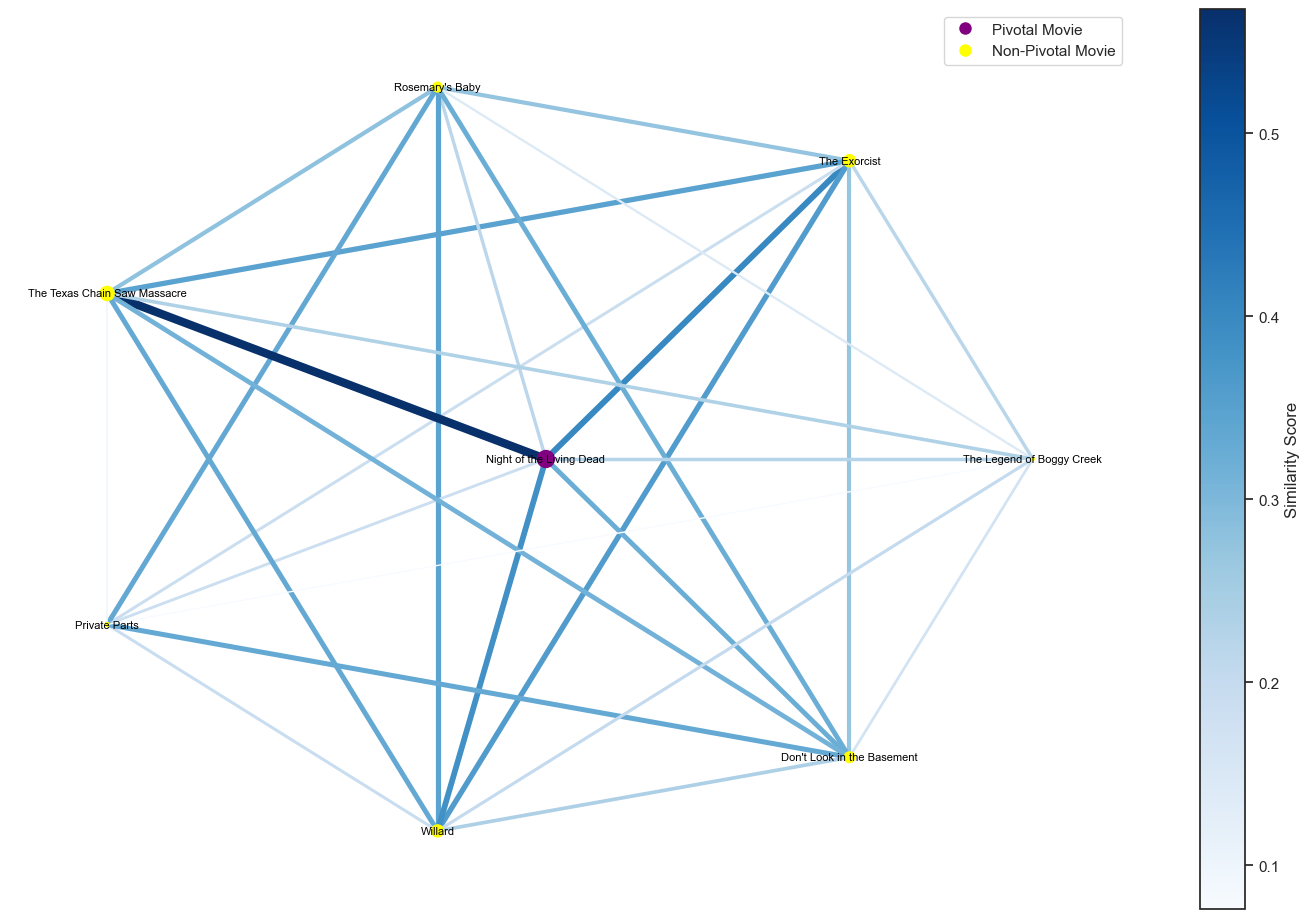

In [121]:
import networkx as nx
import math
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def compute_plot_similarity(movie1_id, movie2_id):
    return similarity_matrix[movie1_id, movie2_id]

# Assuming id_wiki_list is a list of id_wiki values
# Add more id_wiki values as needed

# Specify the id_wiki for the node you want to label as 'pivotal'


# Create a graph
G = nx.Graph()

# Dictionary to store cumulative similarity scores for each node
cumulative_similarity_scores = {}

# Iterate over pairs of id_wiki values
for i in range(len(id_wiki_list)):
    for j in range(i+1, len(id_wiki_list)):
        movie1_id = merged_df[merged_df['id_wiki'] == id_wiki_list[i]].index[0]
        movie2_id = merged_df[merged_df['id_wiki'] == id_wiki_list[j]].index[0]

        movie1_name = merged_df.loc[movie1_id, 'name']
        movie2_name = merged_df.loc[movie2_id, 'name']

        # Assuming compute_plot_similarity returns a single similarity score
        similarity_score = compute_plot_similarity(movie1_id, movie2_id)

        # Update cumulative similarity scores for each node
        cumulative_similarity_scores[movie1_id] = cumulative_similarity_scores.get(movie1_id, 0) + similarity_score
        cumulative_similarity_scores[movie2_id] = cumulative_similarity_scores.get(movie2_id, 0) + similarity_score

        # Add nodes
        G.add_node(movie1_id, label=movie1_name, size=cumulative_similarity_scores[movie1_id])
        G.add_node(movie2_id, label=movie2_name, size=cumulative_similarity_scores[movie2_id])

        # Add edge with weight
        G.add_edge(movie1_id, movie2_id, weight=similarity_score)

central_node = max(G.nodes, key=lambda n: cumulative_similarity_scores[n])

# Set a custom color for the pivotal node


# Determine the number of nodes excluding the central node
num_other_nodes = len(G.nodes) -1 

# Set the radius of the circle
radius = 2.0  # You can adjust this value based on your preference

# Calculate the angle between each node on the circle
angle_increment = 2 * math.pi / num_other_nodes

# Calculate positions for each node on the circle
pos = {central_node: [0, 0]}  # Set the position of the central node
j=0
for i, node in enumerate(G.nodes):
    
    if node != central_node:
        j=j+1
        angle = j * angle_increment
        x = radius * math.cos(angle) + pos[central_node][0]
        y = radius * math.sin(angle) + pos[central_node][1]
        pos[node] = [x, y]

# Extract edge weights
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Normalize edge weights to use for scaling edge thickness
max_weight = max(edge_weights)
min_weight = min(edge_weights)
scaled_weights = [5 * (weight - min_weight) / (max_weight - min_weight) + 1 for weight in edge_weights]

# Extract node sizes, scaling them with a square root function
sqrt_scaling_factor = 6 # Adjust this factor for square root scaling
node_sizes = [cumulative_similarity_scores[n] ** sqrt_scaling_factor  for n in G.nodes]

# Extract node colors
node_colors = ['purple' if G.nodes[n]['label'] == pivotal else 'yellow' for n in G.nodes]
node_labels = {n: G.nodes[n]['label'] for n in G.nodes}
# Set up a colormap based on similarity scores
cmap = plt.cm.get_cmap('Blues')  # Using 'Blues' colormap for shades of blue  # Using 'viridis' for lower values
norm = Normalize(vmin=min_weight, vmax=max_weight)

# Set a larger plot size
plt.figure(figsize=(14, 9))

# Draw the network with colored edges and edge thickness proportional to similarity score
# Assuming node_labels is a dictionary with node labels
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=node_sizes, node_color=node_colors, width=scaled_weights, edge_color=edge_weights, edge_cmap=cmap, edge_vmin=min_weight, edge_vmax=max_weight, font_size=8, font_color='black')


# Add a colorbar to show the mapping between similarity scores and colors
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Similarity Score')
legend_labels = {'Pivotal Movie': 'purple', 'Non-Pivotal Movie': 'yellow'}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in legend_labels.items()]
plt.legend(handles=legend_handles, loc='upper right')


# Save the figure with tight layout
plt.savefig('network_plot_colored_edges_centered_pivotal.png', bbox_inches='tight')

plt.show()


### b) (TO COMPLETE)

## 4) Analysis of the results 

We finally got the set of pivotals movies but we need to do an assessment of these results. 

### a) Convergence of the methods

### b) Correlation between pivotal movies

### c) How to make a pivotal movie ?